In [1]:
pip install yfinance pandas matplotlib numpy scikit-learn tensorflow

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_absolute_error

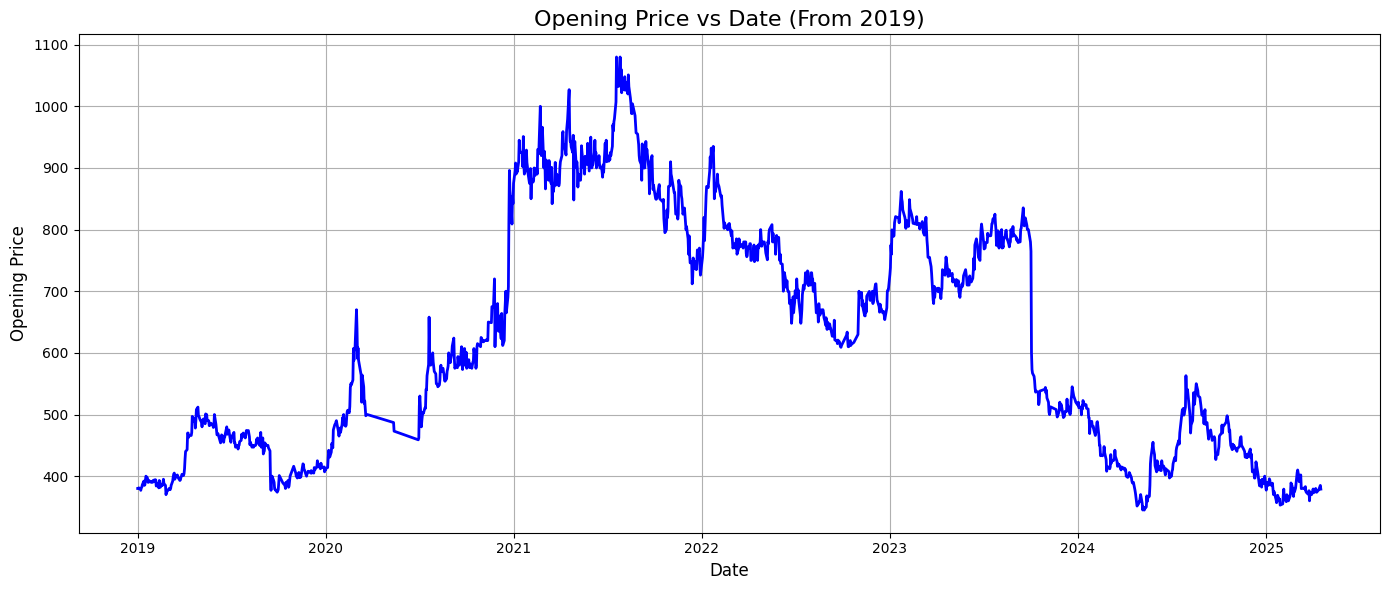

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load your data (replace 'your_file.csv' with the actual file name)
data = pd.read_csv('/content/nic_asia_price_history.csv')

# Reverse the order of rows
df = data.iloc[::-1].reset_index(drop=True)

# Step 2: Remove 'S.N.' column if it exists
if 'S.N.' in df.columns:
    df = df.drop(columns=['S.N.'])

# Step 3: Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Step 4: Clean numeric columns (remove commas and convert to float)
numeric_cols = ['Open', 'High', 'Low', 'Ltp', '% Change', 'Qty', 'Turnover']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

# Step 5: Drop rows with missing dates
df = df.dropna(subset=['Date'])

# Step 6: Filter from 2019-01-01 onwards
df = df[df['Date'] >= '2019-01-01']

# Step 7: Sort by date just in case
df = df.sort_values(by='Date').reset_index(drop=True)

# Step 8: Plot Opening Price vs Date
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Open'], color='blue', linewidth=2)
plt.title('Opening Price vs Date (From 2019)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Opening Price', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import numpy as np

# --- Feature Calculations ---

# 1. RSI (Relative Strength Index)
def compute_rsi(series, period=15):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -1 * delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df['Ltp'], period=14)

# 2. MACD (Moving Average Convergence Divergence)
exp1 = df['Ltp'].ewm(span=12, adjust=False).mean()
exp2 = df['Ltp'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 3. ATR (Average True Range)
df['H-L'] = df['High'] - df['Low']
df['H-PC'] = abs(df['High'] - df['Ltp'].shift(1))
df['L-PC'] = abs(df['Low'] - df['Ltp'].shift(1))
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()

# 4. OBV (On-Balance Volume)
df['OBV'] = (np.sign(df['Ltp'].diff()) * df['Qty']).fillna(0).cumsum()

# 5. Bollinger Bands Width
rolling_mean = df['Ltp'].rolling(window=20).mean()
rolling_std = df['Ltp'].rolling(window=20).std()
df['Bollinger_Width'] = (2 * rolling_std) / rolling_mean

# 6. EMA (Exponential Moving Average)
df['EMA_15'] = df['Ltp'].ewm(span=15, adjust=False).mean()

# 7. Volume Moving Average
df['Volume_MA'] = df['Qty'].rolling(window=15).mean()

# 8. ROC (Rate of Change)
df['ROC'] = df['Ltp'].pct_change(periods=5)

# 9. Candle Body to Wick Ratio
df['Body'] = abs(df['Open'] - df['Ltp'])
df['Wick'] = df['High'] - df['Low']
df['Body_Wick_Ratio'] = df['Body'] / df['Wick'].replace(0, np.nan)

# 10. Lagged Closing Price
df['Ltp_Lag1'] = df['Ltp'].shift(1)

# 11. Rolling Standard Deviation
df['Rolling_STD'] = df['Ltp'].rolling(window=15).std()

# 12. Daily Percentage Change
df['Daily_Perc_Change'] = df['Ltp'].pct_change()

# 13. Day of Week
df['Day_of_Week'] = df['Date'].dt.dayofweek

# Final cleanup for extra columns created during intermediate steps
df_features = df[[
    'Date', 'Open', 'High', 'Low', 'Ltp', 'Qty',
    'RSI', 'MACD', 'MACD_Signal', 'ATR', 'OBV',
    'Bollinger_Width', 'EMA_15', 'Volume_MA', 'ROC',
    'Body_Wick_Ratio', 'Ltp_Lag1', 'Rolling_STD',
    'Daily_Perc_Change', 'Day_of_Week'
]].dropna()

df_features.head()


,Date,Open,High,Low,Ltp,Qty,RSI,MACD,MACD_Signal,ATR,OBV,Bollinger_Width,EMA_15,Volume_MA,ROC,Body_Wick_Ratio,Ltp_Lag1,Rolling_STD,Daily_Perc_Change,Day_of_Week
19,2019-01-28,391.0,394.0,391.0,393.0,12704.0,62.790698,2.989590,2.806585,6.142857,112408.0,0.029944,389.677886,26877.333333,0.010283,0.666667,391.0,4.161044,0.005115,0
20,2019-01-29,391.0,392.0,389.0,390.0,24692.0,52.500000,2.734646,2.792197,5.714286,87716.0,0.028494,389.718150,26760.333333,0.000000,0.333333,393.0,3.494213,-0.007634,1
21,2019-01-30,390.0,392.0,390.0,392.0,23118.0,52.500000,2.663283,2.766414,5.500000,110834.0,0.027739,390.003382,25403.533333,0.000000,1.000000,390.0,3.422614,0.005128,2
22,2019-01-31,393.0,394.0,390.0,391.0,11447.0,60.000000,2.497249,2.712581,5.142857,99387.0,0.026937,390.127959,24259.000000,-0.002551,0.500000,392.0,3.411465,-0.002551,3
23,2019-02-03,394.0,395.0,390.0,390.0,22031.0,55.882353,2.258934,2.621852,5.071429,77356.0,0.022576,390.111964,20761.400000,-0.002558,0.800000,391.0,2.825058,-0.002558,6


In [5]:
from sklearn.preprocessing import MinMaxScaler

# Correct list of feature columns
feature_cols = [
    'Open', 'High', 'Low', 'Ltp', 'Qty',
    'RSI', 'MACD', 'MACD_Signal', 'ATR', 'OBV',
    'Bollinger_Width', 'EMA_15', 'Volume_MA', 'ROC',
    'Body_Wick_Ratio', 'Ltp_Lag1', 'Rolling_STD',
    'Daily_Perc_Change', 'Day_of_Week'
]

# Initialize scaler
scaler = MinMaxScaler()

# Apply scaling
scaled_features = scaler.fit_transform(df_features[feature_cols])

# Create a DataFrame with scaled features
scaled_df = pd.DataFrame(scaled_features, columns=feature_cols)

# Add back the date column for tracking
scaled_df['Date'] = df_features['Date'].values


In [6]:
scaled_df

,Open,High,Low,Ltp,Qty,RSI,MACD,MACD_Signal,ATR,OBV,Bollinger_Width,EMA_15,Volume_MA,ROC,Body_Wick_Ratio,Ltp_Lag1,Rolling_STD,Daily_Perc_Change,Day_of_Week,Date
0,0.062585,0.057427,0.070131,0.063490,0.016836,0.655060,0.550030,0.530381,0.038710,0.448283,0.052452,0.045559,0.039918,0.531500,0.666667,0.060735,0.021354,0.726980,0.000000,2019-01-28
1,0.062585,0.054699,0.067291,0.059358,0.032798,0.547703,0.548175,0.530264,0.029032,0.446165,0.048613,0.045619,0.039627,0.513201,0.333333,0.063490,0.015799,0.690297,0.166667,2019-01-29
2,0.061224,0.054699,0.068711,0.062113,0.030702,0.547703,0.547656,0.530054,0.024194,0.448148,0.046612,0.046046,0.036252,0.513201,1.000000,0.059358,0.015203,0.727017,0.333333,2019-01-30
3,0.065306,0.057427,0.068711,0.060735,0.015162,0.625946,0.546448,0.529617,0.016129,0.447166,0.044489,0.046233,0.033406,0.508661,0.500000,0.062113,0.015110,0.704921,0.500000,2019-01-31
4,0.066667,0.058791,0.068711,0.059358,0.029255,0.582989,0.544713,0.528880,0.014516,0.445276,0.032943,0.046209,0.024706,0.508649,0.800000,0.060735,0.010225,0.704902,1.000000,2019-02-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,0.040816,0.036966,0.047416,0.042198,0.051437,0.575385,0.521344,0.494298,0.156210,0.016870,0.046340,0.022991,0.076448,0.539315,0.635000,0.038838,0.024885,0.730979,0.500000,2025-04-10
1414,0.044898,0.038194,0.041738,0.040132,0.052669,0.567747,0.522756,0.495722,0.162500,0.013473,0.044575,0.023258,0.078335,0.503552,0.220225,0.042198,0.025957,0.700829,1.000000,2025-04-13
1415,0.051701,0.042423,0.047984,0.043906,0.037487,0.665611,0.525516,0.497477,0.157016,0.015893,0.037949,0.024005,0.078660,0.522457,0.555263,0.040132,0.028445,0.733227,0.166667,2025-04-15
1416,0.054422,0.045151,0.050256,0.042653,0.035726,0.619698,0.527181,0.499253,0.150887,0.013586,0.037846,0.024487,0.073461,0.538904,0.891250,0.043906,0.025978,0.705349,0.333333,2025-04-16


In [7]:
SEQ_LEN = 15

def create_sequences(data, target_column='Open'):
    X_seq, indicators_seq, y_seq = [], [], []
    for i in range(len(data) - SEQ_LEN):
        past = data.iloc[i:i+SEQ_LEN]
        future = data.iloc[i+SEQ_LEN]

        x_main = past[['Open', 'High', 'Low', 'Ltp', 'Qty']].values  # Sequential features
        x_indicators = past[['RSI', 'MACD', 'MACD_Signal', 'ATR', 'OBV',
    'Bollinger_Width', 'EMA_15', 'Volume_MA', 'ROC',
    'Body_Wick_Ratio', 'Ltp_Lag1', 'Rolling_STD',
    'Daily_Perc_Change', 'Day_of_Week']].iloc[-1].values  # Last day indicators

        X_seq.append(x_main)
        indicators_seq.append(x_indicators)
        y_seq.append(future[target_column])  # target is next day Open price

    return np.array(X_seq), np.array(indicators_seq), np.array(y_seq)

X_seq, X_indicators, y = create_sequences(scaled_df, "Open")

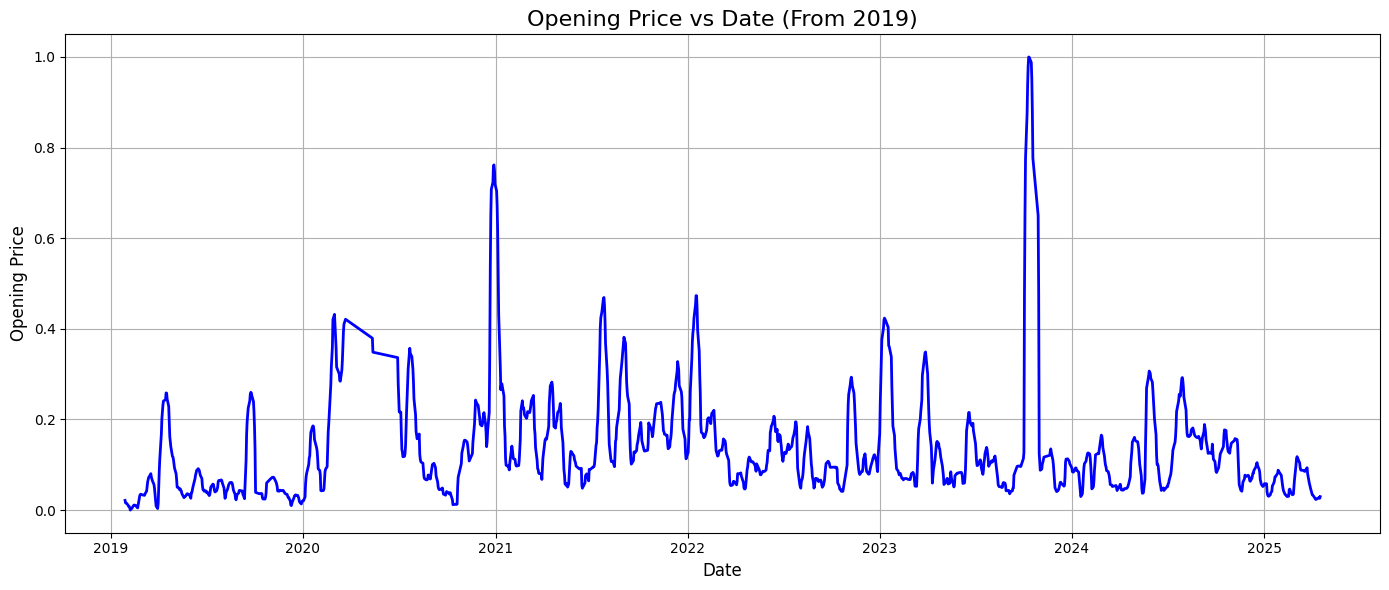

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(scaled_df['Date'], scaled_df['Rolling_STD'], color='blue', linewidth=2)
plt.title('Opening Price vs Date (From 2019)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Opening Price', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# LSTM model with technical indicators
def lstm_model(seq_len, seq_features, num_indicators, units=256):
    # Sequential data input
    seq_input = Input(shape=(seq_len, seq_features))
    x = layers.LSTM(units, return_sequences=True)(seq_input)
    x = layers.Dropout(0.1)(x)
    x = layers.LSTM(units)(x)
    x = layers.Dropout(0.1)(x)

    # Technical indicators input
    indicators_input = Input(shape=(num_indicators,))

    # Concatenate sequential features with indicators
    concatenated = layers.concatenate([x, indicators_input])

    # Final dense layers
    x = layers.Dense(32, activation='relu')(concatenated)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=[seq_input, indicators_input], outputs=outputs)
    return model

# GRU model with technical indicators
def gru_model(seq_len, seq_features, num_indicators, units=256):
    # Sequential data input
    seq_input = Input(shape=(seq_len, seq_features))
    x = layers.GRU(units, return_sequences=True)(seq_input)
    x = layers.Dropout(0.1)(x)
    x = layers.GRU(units)(x)
    x = layers.Dropout(0.1)(x)

    # Technical indicators input
    indicators_input = Input(shape=(num_indicators,))

    # Concatenate sequential features with indicators
    concatenated = layers.concatenate([x, indicators_input])

    # Final dense layers
    x = layers.Dense(32, activation='relu')(concatenated)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=[seq_input, indicators_input], outputs=outputs)
    return model

# Bidirectional LSTM model with technical indicators
def bidirectional_lstm_model(seq_len, seq_features, num_indicators, units=256):
    # Sequential data input
    seq_input = Input(shape=(seq_len, seq_features))
    x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(seq_input)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(units))(x)
    x = layers.Dropout(0.1)(x)

    # Technical indicators input
    indicators_input = Input(shape=(num_indicators,))

    # Concatenate sequential features with indicators
    concatenated = layers.concatenate([x, indicators_input])

    # Final dense layers
    x = layers.Dense(32, activation='relu')(concatenated)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=[seq_input, indicators_input], outputs=outputs)
    return model

# Positional Encoding Layer for Transformer
class PositionalEncoding(layers.Layer):
    def __init__(self, max_steps=1000, d_model=128, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_steps = max_steps
        self.d_model = d_model
        self.positional_encoding = self._get_positional_encoding(max_steps, d_model)

    def _get_positional_encoding(self, max_steps, d_model):
        pos_enc = np.zeros((max_steps, d_model))
        for pos in range(max_steps):
            for i in range(0, d_model, 2):
                pos_enc[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
                if i + 1 < d_model:  # Ensure we don't go out of bounds
                    pos_enc[pos, i + 1] = np.cos(pos / (10000 ** ((i + 1) / d_model)))
        return tf.cast(pos_enc, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'max_steps': self.max_steps,
            'd_model': self.d_model
        })
        return config

# Transformer Encoder Layer
def encoder_layer(units, d_model, num_heads, dropout):
    inputs = layers.Input(shape=(None, d_model))
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attention = layers.Dropout(dropout)(attention)
    attention = layers.LayerNormalization(epsilon=1e-6)(attention + inputs)

    outputs = layers.Dense(units=units, activation='relu')(attention)
    outputs = layers.Dense(units=d_model)(outputs)
    outputs = layers.Dropout(dropout)(outputs)
    outputs = layers.LayerNormalization(epsilon=1e-6)(outputs + attention)

    return models.Model(inputs=inputs, outputs=outputs)

# Positional Encoding Layer for Transformer
class PositionalEncoding(layers.Layer):
    def __init__(self, max_steps=1000, d_model=128, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_steps = max_steps
        self.d_model = d_model
        self.positional_encoding = self._get_positional_encoding(max_steps, d_model)

    def _get_positional_encoding(self, max_steps, d_model):
        pos_enc = np.zeros((max_steps, d_model))
        for pos in range(max_steps):
            for i in range(0, d_model, 2):
                pos_enc[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
                if i + 1 < d_model:  # Ensure we don't go out of bounds
                    pos_enc[pos, i + 1] = np.cos(pos / (10000 ** ((i + 1) / d_model)))
        return tf.cast(pos_enc, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'max_steps': self.max_steps,
            'd_model': self.d_model
        })
        return config

# Transformer Encoder Layer
def encoder_layer(units, d_model, num_heads, dropout):
    inputs = layers.Input(shape=(None, d_model))
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attention = layers.Dropout(dropout)(attention)
    attention = layers.LayerNormalization(epsilon=1e-6)(attention + inputs)

    outputs = layers.Dense(units=units, activation='relu')(attention)
    outputs = layers.Dense(units=d_model)(outputs)
    outputs = layers.Dropout(dropout)(outputs)
    outputs = layers.LayerNormalization(epsilon=1e-6)(outputs + attention)

    return models.Model(inputs=inputs, outputs=outputs)

# Transformer model with technical indicators
def transformer_model(seq_len, seq_features, num_indicators, units=256):
    # Set transformer-specific parameters
    d_model = units
    num_heads = 4
    num_layers = 4
    dropout = 0.1

    # Sequential data input
    seq_input = Input(shape=(seq_len, seq_features))

    # Embedding
    x = layers.Dense(d_model)(seq_input)

    # Positional Encoding
    x = PositionalEncoding(seq_len, d_model)(x)

    # Encoder Layers
    for _ in range(num_layers):
        encoder = encoder_layer(units=d_model*2, d_model=d_model, num_heads=num_heads, dropout=dropout)
        x = encoder(x)

    # Global pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Technical indicators input
    indicators_input = Input(shape=(num_indicators,))

    # Concatenate sequential features with indicators
    concatenated = layers.concatenate([x, indicators_input])

    # Final dense layers
    x = layers.Dense(32, activation='relu')(concatenated)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=[seq_input, indicators_input], outputs=outputs)
    return model
# Training function
def train_model(model_func, model_name, X_seq_train, X_ind_train, y_train,
               X_seq_val, X_ind_val, y_val,
               seq_length, seq_features, num_indicators,
               epochs=50, batch_size=32):

    # Create model
    model = model_func(seq_length, seq_features, num_indicators)

    # Print model summary
    print(f"\n{'='*50}")
    print(f"Training {model_name} model...")
    print(f"{'='*50}")
    model.summary()

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'best_{model_name}_model.h5',
                                monitor='val_loss',
                                save_best_only=True,
                                mode='min',
                                verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.5,
                                patience=5,
                                min_lr=1e-6,
                                verbose=1)
    callbacks = [early_stopping, checkpoint, reduce_lr]

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                 loss=MeanSquaredError(),
                 metrics=['mae'])

    # Train the model
    history = model.fit(
        [X_seq_train, X_ind_train], y_train,
        epochs=epochs,
        validation_data=([X_seq_val, X_ind_val], y_val),
        batch_size=batch_size,
        callbacks=callbacks
    )

    # Load the best model
    if model_name == 'Transformer':
        new_model = model_func(seq_length, seq_features, num_indicators)

        # Trying to load just the weights
        try:
            new_model.load_weights(f'best_{model_name}_model.h5')
            print("Weights loaded successfully!")
            model = new_model
        except Exception as e:
            print(f"Error loading weights: {e}")
            print("Using model with best weights from training session")
    else:
        # Original loading for other models
        try:
            model = tf.keras.models.load_model(f'best_{model_name}_model.h5')
        except Exception as e:
            print(f"Error loading model: {e}")
            print("Using model with best weights from training session")

    return model, history

# Evaluation function
def evaluate_model(model, model_name,
                  X_seq_train, X_ind_train, y_train,
                  X_seq_val, X_ind_val, y_val,
                  X_seq_test, X_ind_test, y_test,
                  scaler_y):

    # Make predictions
    train_pred = model.predict([X_seq_train, X_ind_train])
    val_pred = model.predict([X_seq_val, X_ind_val])
    test_pred = model.predict([X_seq_test, X_ind_test])

    # Function to calculate MAE and MAPE
    def evaluate_mae_mape(y_true, y_pred):
        # Calculate MAE
        mae = mean_absolute_error(y_true, y_pred)

        # Calculate MAPE (Mean Absolute Percentage Error)
        # Adding a small epsilon to avoid division by zero
        epsilon = 1e-10
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

        return mae, mape

    # Inverse transform to original scale if scaler_y is provided
    if scaler_y is not None:
        # Create dummy arrays for inverse transformation
        if isinstance(scaler_y, MinMaxScaler):
            n_features = len(scaler_y.feature_names_in_) if hasattr(scaler_y, 'feature_names_in_') else len(scaler_y.feature_range_)

            # Function to create dummy array and insert values at first position
            def inverse_scale_with_dummy(values):
                if values.ndim == 1:
                    values = values.reshape(-1, 1)
                dummy = np.zeros((values.shape[0], n_features))
                dummy[:, 0] = values[:, 0]  # Assuming first column is 'Open' price
                return scaler_y.inverse_transform(dummy)[:, 0]

            # Apply inverse scaling
            train_pred = inverse_scale_with_dummy(train_pred)
            val_pred = inverse_scale_with_dummy(val_pred)
            test_pred = inverse_scale_with_dummy(test_pred)

            # Also inverse transform target values
            y_train_orig = inverse_scale_with_dummy(y_train.reshape(-1, 1))
            y_val_orig = inverse_scale_with_dummy(y_val.reshape(-1, 1))
            y_test_orig = inverse_scale_with_dummy(y_test.reshape(-1, 1))
        else:
            # Fallback for other scalers
            train_pred = scaler_y.inverse_transform(train_pred)
            val_pred = scaler_y.inverse_transform(val_pred)
            test_pred = scaler_y.inverse_transform(test_pred)
            y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1))
            y_val_orig = scaler_y.inverse_transform(y_val.reshape(-1, 1))
            y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    else:
        # If no scaler provided, use the data as is
        y_train_orig = y_train.reshape(-1, 1)
        y_val_orig = y_val.reshape(-1, 1)
        y_test_orig = y_test.reshape(-1, 1)
        # Reshape predictions to match target shape
        train_pred = train_pred.reshape(-1, 1)
        val_pred = val_pred.reshape(-1, 1)
        test_pred = test_pred.reshape(-1, 1)

    # Evaluate for training data
    train_mae, train_mape = evaluate_mae_mape(y_train_orig, train_pred)
    print(f"{model_name} - Training Data - MAE: {train_mae:.4f}, MAPE: {train_mape:.2f}%")

    # Evaluate for validation data
    val_mae, val_mape = evaluate_mae_mape(y_val_orig, val_pred)
    print(f"{model_name} - Validation Data - MAE: {val_mae:.4f}, MAPE: {val_mape:.2f}%")

    # Evaluate for test data
    test_mae, test_mape = evaluate_mae_mape(y_test_orig, test_pred)
    print(f"{model_name} - Test Data - MAE: {test_mae:.4f}, MAPE: {test_mape:.2f}%")

    results = {
        'train_pred': train_pred,
        'val_pred': val_pred,
        'test_pred': test_pred,
        'y_train': y_train_orig,
        'y_val': y_val_orig,
        'y_test': y_test_orig,
        'metrics': {
            'train_mae': train_mae,
            'train_mape': train_mape,
            'val_mae': val_mae,
            'val_mape': val_mape,
            'test_mae': test_mae,
            'test_mape': test_mape
        }
    }

    return results

# Function to predict future values
def predict_future(model, model_name, last_seq_sequence, last_indicators,
                  scaler_seq, scaler_ind, scaler_y,
                  sequence_length, seq_features,
                  days_to_predict=30):

    print(f"\n{'-'*50}")
    print(f"Predicting next {days_to_predict} days using {model_name} model...")
    print(f"{'-'*50}")

    # Initialize with the last known sequence
    # Make sure it's a 3D array with shape (1, sequence_length, seq_features)
    curr_sequence = last_seq_sequence.copy()
    if len(curr_sequence.shape) == 2:
        curr_sequence = curr_sequence.reshape(1, curr_sequence.shape[0], curr_sequence.shape[1])

    # Make sure indicators are 2D with shape (1, num_indicators)
    curr_indicators = last_indicators.copy()
    if len(curr_indicators.shape) == 1:
        curr_indicators = curr_indicators.reshape(1, -1)

    future_predictions = []
    future_dates = []

    # Get the last known date
    last_date = pd.Timestamp.now()  # As a placeholder

    # Predict one day at a time and update the sequence
    for i in range(days_to_predict):
        # Make prediction for the next day
        next_day_scaled = model.predict([curr_sequence, curr_indicators])

        # Inverse transform the prediction if scaler is provided
        if scaler_y is not None:
            # Create a dummy array with zeros for all other features
            if isinstance(scaler_y, MinMaxScaler):
                # Get number of features in scaler
                n_features = len(scaler_y.feature_names_in_) if hasattr(scaler_y, 'feature_names_in_') else len(scaler_y.feature_range_)

                # Create a dummy array with the same number of features as the original scaler
                dummy = np.zeros((1, n_features))
                # Place the predicted value in the first position (assuming 'Open' is the first feature)
                dummy[0, 0] = next_day_scaled[0, 0]
                # Now inverse transform
                next_day = scaler_y.inverse_transform(dummy)[0, 0]
            else:
                # Fallback to simple inverse transform if it's not a MinMaxScaler
                next_day = scaler_y.inverse_transform(next_day_scaled)[0, 0]
        else:
            next_day = next_day_scaled[0, 0]

        # Add the prediction to our results
        future_predictions.append(next_day)

        # Calculate the next date
        next_date = last_date + pd.Timedelta(days=i+1)
        future_dates.append(next_date)

        # Update sequence for next prediction
        if seq_features > 1:
            # Extract the last timestep's features
            last_features = curr_sequence[0, -1, :].copy()

            # Update the first feature with our prediction (still in scaled form)
            last_features[0] = next_day_scaled[0, 0]

            # Reshape to (1, 1, seq_features) for concatenation
            new_data_point = last_features.reshape(1, 1, seq_features)

            # Drop the first timestep and append the new one
            curr_sequence = np.concatenate([curr_sequence[:, 1:, :], new_data_point], axis=1)
        else:
            # If we only have one feature, simpler update
            new_point = next_day_scaled.reshape(1, 1, 1)
            curr_sequence = np.concatenate([curr_sequence[:, 1:, :], new_point], axis=1)

        # Print the prediction
        print(f"Day {i+1} ({next_date.strftime('%Y-%m-%d')}): Predicted Price = Rs.{next_day:.2f}")

    return future_predictions, future_dates

# Visualization function - combined plot
def plot_predictions(results, model_name, stock_name="Stock"):
    # Extract data
    y_train = results['y_train']
    y_val = results['y_val']
    y_test = results['y_test']
    train_pred = results['train_pred']
    val_pred = results['val_pred']
    test_pred = results['test_pred']

    # Check if future predictions exist in results
    has_future = 'future_pred' in results and 'future_dates' in results
    future_pred = results.get('future_pred', [])

    # Plot combined results
    plt.figure(figsize=(15, 8))

    # Actual data
    plt.plot(np.arange(len(y_train)), y_train, color='blue', label='Training Data')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, color='orange', label='Validation Data')
    plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)),
             y_test, color='green', label='Test Data')

    # Predictions
    plt.plot(np.arange(len(train_pred)), train_pred, color='lightgreen', linestyle='--', label='Training Prediction')
    plt.plot(np.arange(len(y_train), len(y_train) + len(val_pred)),
             val_pred, color='black', linestyle='--', label='Validation Prediction')
    plt.plot(np.arange(len(y_train) + len(val_pred), len(y_train) + len(val_pred) + len(test_pred)),
             test_pred, color='red', linestyle='--', label='Test Prediction')

    # Add future predictions if available
    if has_future:
        future_start_idx = len(y_train) + len(y_val) + len(y_test)
        plt.plot(np.arange(future_start_idx, future_start_idx + len(future_pred)),
                 future_pred, color='blue', label='Future Prediction')

    plt.title(f"{stock_name} Price Prediction using {model_name} - All Data")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{model_name}_{stock_name}_all_prediction.png")
    plt.show()

    # Validation Plot
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_val)), y_val, color='blue', label='Actual Validation Data')
    plt.plot(np.arange(len(val_pred)), val_pred, color='red', linestyle='--', label='Validation Prediction')
    plt.title(f"{stock_name} Validation Data Prediction using {model_name}")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{model_name}_{stock_name}_validation_prediction.png")
    plt.show()

    # Test Plot with Future Predictions
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_test)), y_test, color='green', label='Actual Test Data')
    plt.plot(np.arange(len(test_pred)), test_pred, color='red', linestyle='--', label='Test Prediction')

    # Add future predictions to the test plot
    if has_future:
        future_start_idx = len(y_test)
        plt.plot(np.arange(future_start_idx, future_start_idx + len(future_pred)),
                 future_pred, color='blue', label='Future Prediction')

    plt.title(f"{stock_name} Test Data Prediction using {model_name}")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{model_name}_{stock_name}_test_prediction.png")
    plt.show()

# Compare model performances
def compare_models(model_results, stock_name="Stock"):
    models = list(model_results.keys())

    # Create metrics dataframe
    metrics_data = []
    for model_name, results in model_results.items():
        metrics = results['metrics']
        metrics_data.append({
            'Model': model_name,
            'Train MAE': metrics['train_mae'],
            'Train MAPE (%)': metrics['train_mape'],
            'Val MAE': metrics['val_mae'],
            'Val MAPE (%)': metrics['val_mape'],
            'Test MAE': metrics['test_mae'],
            'Test MAPE (%)': metrics['test_mape']
        })

    metrics_df = pd.DataFrame(metrics_data)
    print("\nModel Performance Comparison:")
    print(metrics_df)

    # Plot MAE and MAPE comparison
    plt.figure(figsize=(14, 6))

    # Bar chart for MAE
    plt.subplot(1, 2, 1)
    x = np.arange(len(models))
    width = 0.2

    plt.bar(x - width, [model_results[m]['metrics']['train_mae'] for m in models],
            width, label='Train MAE', color='lightblue')
    plt.bar(x, [model_results[m]['metrics']['val_mae'] for m in models],
            width, label='Val MAE', color='orange')
    plt.bar(x + width, [model_results[m]['metrics']['test_mae'] for m in models],
            width, label='Test MAE', color='lightgreen')

    plt.xlabel('Models')
    plt.ylabel('MAE')
    plt.title(f'{stock_name} Price Prediction - MAE Comparison')
    plt.xticks(x, models)
    plt.legend()

    # Bar chart for MAPE
    plt.subplot(1, 2, 2)
    plt.bar(x - width, [model_results[m]['metrics']['train_mape'] for m in models],
            width, label='Train MAPE', color='lightblue')
    plt.bar(x, [model_results[m]['metrics']['val_mape'] for m in models],
            width, label='Val MAPE', color='orange')
    plt.bar(x + width, [model_results[m]['metrics']['test_mape'] for m in models],
            width, label='Test MAPE', color='lightgreen')

    plt.xlabel('Models')
    plt.ylabel('MAPE (%)')
    plt.title(f'{stock_name} Price Prediction - MAPE Comparison')
    plt.xticks(x, models)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{stock_name}_model_comparison.png")
    plt.show()

    return metrics_df

# Main function to run the entire process
def run_models(X_seq_train, X_ind_train, y_train,
              X_seq_val, X_ind_val, y_val,
              X_seq_test, X_ind_test, y_test,
              sequence_length, seq_features, num_indicators,
              scaler_y, scaler_seq=None, scaler_ind=None,
              epochs=50, batch_size=32, stock_name="Stock"):

    # Model architectures dictionary
    model_builders = {
        'LSTM': lstm_model,
        'BiLSTM': bidirectional_lstm_model,
        'GRU': gru_model,
        'Transformer': transformer_model
    }

    # Train and evaluate all models
    model_results = {}

    # Get the last sequences from test data for future predictions
    last_seq_sequence = X_seq_test[-1].copy()
    last_indicators = X_ind_test[-1].copy()

    for model_name, model_func in model_builders.items():
        # Train
        trained_model, history = train_model(
            model_func, model_name,
            X_seq_train, X_ind_train, y_train,
            X_seq_val, X_ind_val, y_val,
            sequence_length, seq_features, num_indicators,
            epochs, batch_size
        )

        # Evaluate
        results = evaluate_model(
            trained_model, model_name,
            X_seq_train, X_ind_train, y_train,
            X_seq_val, X_ind_val, y_val,
            X_seq_test, X_ind_test, y_test,
            scaler_y
        )

        # Predict future 7 days
        future_pred, future_dates = predict_future(
            trained_model, model_name,
            last_seq_sequence, last_indicators,
            scaler_seq, scaler_ind, scaler_y,
            sequence_length, seq_features,
            days_to_predict=7
        )

        # Add future predictions to results
        results['future_pred'] = future_pred
        results['future_dates'] = future_dates

        # Store results
        model_results[model_name] = results

        # Plot individual model results
        plot_predictions(results, model_name, stock_name)

    # Compare all models
    metrics_df = compare_models(model_results, stock_name)

    return model_results, metrics_df

# Example usage
def prepare_and_run_example():
    """
    Example usage showing how to prepare data and run the pipeline.
    This assumes you already have processed data in the format shown in your code.
    """
    # Placeholder for actual data preparation
    SEQ_LEN = 15

    # Example shapes for dummy data
    num_samples = 1000
    seq_features = 5  # Open, High, Low, Ltp, Qty
    num_indicators = 14  # RSI, MACD, etc.

    # Create dummy data for demonstration
    X_seq = np.random.random((num_samples, SEQ_LEN, seq_features))
    X_indicators = np.random.random((num_samples, num_indicators))
    y = np.random.random((num_samples, 1))

    # Split data (70% train, 15% val, 15% test)
    train_size = int(0.7 * num_samples)
    val_size = int(0.15 * num_samples)

    X_seq_train, X_ind_train, y_train = X_seq[:train_size], X_indicators[:train_size], y[:train_size]
    X_seq_val, X_ind_val, y_val = X_seq[train_size:train_size+val_size], X_indicators[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_seq_test, X_ind_test, y_test = X_seq[train_size+val_size:], X_indicators[train_size+val_size:], y[train_size+val_size:]

    # Run models
    model_results, metrics_df = run_models(
        X_seq_train, X_ind_train, y_train,
        X_seq_val, X_ind_val, y_val,
        X_seq_test, X_ind_test, y_test,
        SEQ_LEN, seq_features, num_indicators,
        epochs=5,  # Low epochs for demonstration
        batch_size=32,
        stock_name="NIC asia Stock"
    )

    return model_results, metrics_df




In [24]:
SEQ_LEN = 15

# Example shapes for dummy data
num_samples = scaled_df.shape[0]
seq_features = 5  # Open, High, Low, Ltp, Qty
num_indicators = 14  # RSI, MACD, etc.

# Split data (70% train, 15% val, 15% test)
train_size = int(0.7 * num_samples)
val_size = int(0.15 * num_samples)

X_seq_train, X_ind_train, y_train = X_seq[:train_size], X_indicators[:train_size], y[:train_size]
X_seq_val, X_ind_val, y_val = X_seq[train_size:train_size+val_size], X_indicators[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_seq_test, X_ind_test, y_test = X_seq[train_size+val_size:], X_indicators[train_size+val_size:], y[train_size+val_size:]



Training LSTM model...


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 15, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 15, 256)   │    268,288 │ input_layer_36[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 15, 256)   │          0 │ lstm_18[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 256)       │    525,312 │ dropout_46[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 256)       │          0 │ lstm_19[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_37      │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 270)       │          0 │ dropout_47[0][0], │
│ (Concatenate)       │                   │            │ input_layer_37[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 32)        │      8,672 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 1)         │         33 │ dense_53[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 802,305 (3.06 MB)

 Trainable params: 802,305 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0192 - mae: 0.1069
Epoch 1: val_loss improved from inf to 0.00379, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0183 - mae: 0.1034 - val_loss: 0.0038 - val_mae: 0.0397 - learning_rate: 0.0010
Epoch 2/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mae: 0.0349
Epoch 2: val_loss improved from 0.00379 to 0.00220, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020 - mae: 0.0348 - val_loss: 0.0022 - val_mae: 0.0288 - learning_rate: 0.0010
Epoch 3/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0292
Epoch 3: val_loss improved from 0.00220 to 0.00206, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - mae: 0.0291 - val_loss: 0.0021 - val_mae: 0.0292 - learning_rate: 0.0010
Epoch 4/50
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.4591e-04 - mae: 0.0231
Epoch 4: val_loss improved from 0.00206 to 0.00160, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.3999e-04 - mae: 0.0229 - val_loss: 0.0016 - val_mae: 0.0237 - learning_rate: 0.0010
Epoch 5/50
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.8251e-04 - mae: 0.0200
Epoch 5: val_loss improved from 0.00160 to 0.00125, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.8431e-04 - mae: 0.0200 - val_loss: 0.0012 - val_mae: 0.0208 - learning_rate: 0.0010
Epoch 6/50
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0237e-04 - mae: 0.0186
Epoch 6: val_loss improved from 0.00125 to 0.00110, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.0065e-04 - mae: 0.0186 - val_loss: 0.0011 - val_mae: 0.0191 - learning_rate: 0.0010
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3514e-04 - mae: 0.0168
Epoch 7: val_loss did not improve from 0.00110
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3476e-04 - mae: 0.0168 - val_loss: 0.0012 - val_mae: 0.0208 - learning_rate: 0.0010
Epoch 8/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6671e-04 - mae: 0.0166
Epoch 8: val_loss improved from 0.00110 to 0.00102, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.8182e-04 - mae: 0.0169 - val_loss: 0.0010 - val_mae: 0.0205 - learning_rate: 0.0010
Epoch 9/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4116e-04 - mae: 0.0160
Epoch 9: val_loss improved from 0.00102 to 0.00102, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4463e-04 - mae: 0.0160 - val_loss: 0.0010 - val_mae: 0.0195 - learning_rate: 0.0010
Epoch 10/50
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7007e-04 - mae: 0.0176
Epoch 10: val_loss improved from 0.00102 to 0.00086, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.5100e-04 - mae: 0.0173 - val_loss: 8.6445e-04 - val_mae: 0.0197 - learning_rate: 0.0010
Epoch 11/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0443e-04 - mae: 0.0150
Epoch 11: val_loss improved from 0.00086 to 0.00083, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0663e-04 - mae: 0.0151 - val_loss: 8.3034e-04 - val_mae: 0.0191 - learning_rate: 0.0010
Epoch 12/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4659e-04 - mae: 0.0142
Epoch 12: val_loss improved from 0.00083 to 0.00074, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4690e-04 - mae: 0.0142 - val_loss: 7.4371e-04 - val_mae: 0.0178 - learning_rate: 0.0010
Epoch 13/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7644e-04 - mae: 0.0137
Epoch 13: val_loss improved from 0.00074 to 0.00074, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7404e-04 - mae: 0.0137 - val_loss: 7.3691e-04 - val_mae: 0.0168 - learning_rate: 0.0010
Epoch 14/50
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0261e-04 - mae: 0.0150
Epoch 14: val_loss improved from 0.00074 to 0.00072, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1223e-04 - mae: 0.0151 - val_loss: 7.1576e-04 - val_mae: 0.0173 - learning_rate: 0.0010
Epoch 15/50
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1859e-04 - mae: 0.0151
Epoch 15: val_loss improved from 0.00072 to 0.00067, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1074e-04 - mae: 0.0149 - val_loss: 6.7126e-04 - val_mae: 0.0160 - learning_rate: 0.0010
Epoch 16/50
24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0125e-04 - mae: 0.0166
Epoch 16: val_loss improved from 0.00067 to 0.00062, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0282e-04 - mae: 0.0166 - val_loss: 6.1804e-04 - val_mae: 0.0152 - learning_rate: 0.0010
Epoch 17/50
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6497e-04 - mae: 0.0138
Epoch 17: val_loss did not improve from 0.00062
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6310e-04 - mae: 0.0138 - val_loss: 6.4506e-04 - val_mae: 0.0162 - learning_rate: 0.0010
Epoch 18/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9853e-04 - mae: 0.0138
Epoch 18: val_loss improved from 0.00062 to 0.00059, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8753e-04 - mae: 0.0137 - val_loss: 5.9044e-04 - val_mae: 0.0140 - learning_rate: 0.0010
Epoch 19/50
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8503e-04 - mae: 0.0117
Epoch 19: val_loss improved from 0.00059 to 0.00058, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8628e-04 - mae: 0.0118 - val_loss: 5.7614e-04 - val_mae: 0.0133 - learning_rate: 0.0010
Epoch 20/50
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5528e-04 - mae: 0.0140
Epoch 20: val_loss did not improve from 0.00058
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6039e-04 - mae: 0.0142 - val_loss: 7.0233e-04 - val_mae: 0.0156 - learning_rate: 0.0010
Epoch 21/50
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1138e-04 - mae: 0.0148
Epoch 21: val_loss did not improve from 0.00058

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9811e-04 - mae: 0.0146 - val_loss: 6.0854e-04 - val_mae: 0.0148 - learning_rate: 0.0010
Epoch 22/50
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9502e-04 - mae: 0.0123
Epoch 22: val_loss did not improve from 0.00058
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9346e-04 - mae: 0.0123 - val_loss: 5.8621e-04 - val_mae: 0.0141

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5471e-04 - mae: 0.0116 - val_loss: 5.6359e-04 - val_mae: 0.0134 - learning_rate: 2.5000e-04
Epoch 29/50
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2340e-04 - mae: 0.0111
Epoch 29: val_loss did not improve from 0.00056
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2853e-04 - mae: 0.0111 - val_loss: 5.7788e-04 - val_mae: 0.0145 - learning_rate: 2.5000e-04
Epoch 30/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5758e-04 - mae: 0.0113
Epoch 30: val_loss improved from 0.00056 to 0.00056, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5720e-04 - mae: 0.0112 - val_loss: 5.6299e-04 - val_mae: 0.0136 - learning_rate: 2.5000e-04
Epoch 31/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7057e-04 - mae: 0.0120
Epoch 31: val_loss improved from 0.00056 to 0.00056, saving model to best_LSTM_model.h5



Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.6959e-04 - mae: 0.0119 - val_loss: 5.6026e-04 - val_mae: 0.0143 - learning_rate: 2.5000e-04
Epoch 32/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3773e-04 - mae: 0.0111
Epoch 32: val_loss improved from 0.00056 to 0.00055, saving model to best_LSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.3881e-04 - mae: 0.0111 - val_loss: 5.5270e-04 - val_mae: 0.0136 - learning_rate: 1.2500e-04
Epoch 33/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.6561e-04 - mae: 0.0117
Epoch 33: val_loss did not improve from 0.00055
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.6416e-04 - mae: 0.0116 - val_loss: 5.6820e-04 - val_mae: 0.0143 - learning_rate: 1.2500e-04
Epoch 34/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1892e-04 - mae: 0.0107
Epoch 34: val_loss did not improve from 0.00055
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1990e-04 - mae: 0.0107 - val_loss: 5.7787e-04 - val_mae: 0.0145 - learning_rate: 1.2500e-04
Epoch 35/50
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8170e-04 - mae: 0.0121
Epoch 35: val_loss did not improve from 0.00055
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7406e-04 - mae: 0.0119 - val_loss: 5.6770e-04 - val_mae: 0.0139 - learning_rate: 1.2500e-04
Epoch 36/50
30/31 ━━━━━━━━━━━━━━━━━━━

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
LSTM - Training Data - MAE: 7.7439, MAPE: 1.14%
LSTM - Validation Data - MAE: 10.0180, MAPE: 1.91%
LSTM - Test Data - MAE: 8.4502, MAPE: 2.05%

--------------------------------------------------
Predicting next 7 days using LSTM model...
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Day 1 (2025-04-19): Predicted Price = Rs.398.27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Day 2 (2025-04-20): Predicted Price = Rs.398.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Day 3 (2025-04-21): Predicted Price = Rs.399.29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 4 (2025-04-22): Predicted Price = Rs.399.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Day 5 (2025-04-23): Predicted Price = Rs.400.25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Day 6 (2025-04-24): Predicted Price = Rs.400.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Day 7 (2025-04-25): Predicted Price = Rs.4

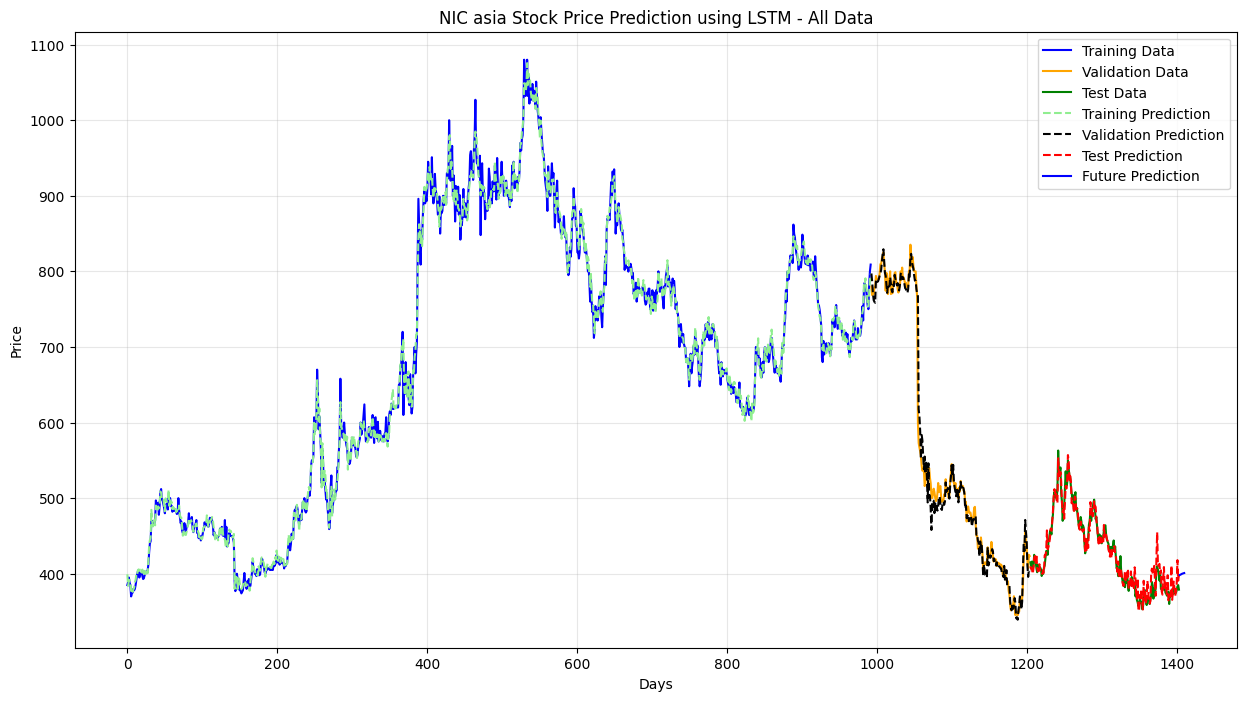

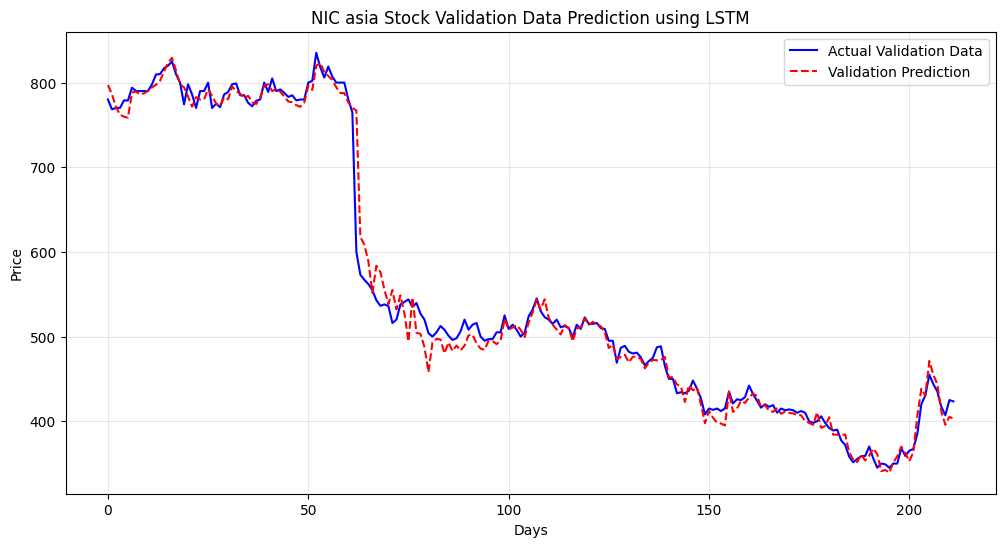

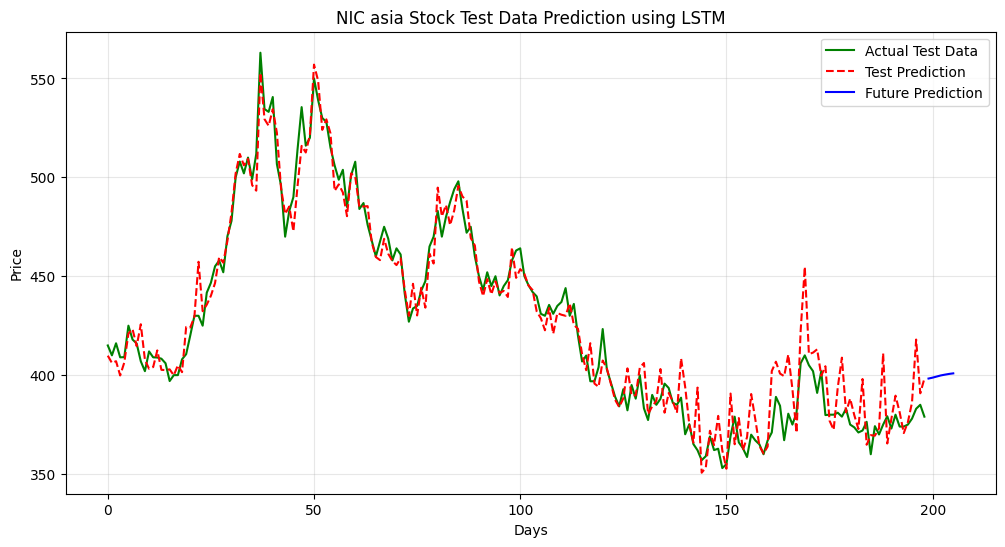


Training BiLSTM model...


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 15, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 15, 512)   │    536,576 │ input_layer_38[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 15, 512)   │          0 │ bidirectional_8[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 512)       │  1,574,912 │ dropout_48[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 512)       │          0 │ bidirectional_9[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_39      │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 526)       │          0 │ dropout_49[0][0], │
│ (Concatenate)       │                   │            │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 32)        │     16,864 │ concatenate_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 1)         │         33 │ dense_55[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,128,385 (8.12 MB)

 Trainable params: 2,128,385 (8.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0484 - mae: 0.1385
Epoch 1: val_loss improved from inf to 0.00255, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0463 - mae: 0.1345 - val_loss: 0.0026 - val_mae: 0.0318 - learning_rate: 0.0010
Epoch 2/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018 - mae: 0.0309
Epoch 2: val_loss improved from 0.00255 to 0.00207, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0018 - mae: 0.0308 - val_loss: 0.0021 - val_mae: 0.0276 - learning_rate: 0.0010
Epoch 3/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015 - mae: 0.0276
Epoch 3: val_loss improved from 0.00207 to 0.00141, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015 - mae: 0.0276 - val_loss: 0.0014 - val_mae: 0.0226 - learning_rate: 0.0010
Epoch 4/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.5828e-04 - mae: 0.0221
Epoch 4: val_loss improved from 0.00141 to 0.00113, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.4509e-04 - mae: 0.0220 - val_loss: 0.0011 - val_mae: 0.0197 - learning_rate: 0.0010
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.6446e-04 - mae: 0.0208
Epoch 5: val_loss improved from 0.00113 to 0.00096, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.6261e-04 - mae: 0.0207 - val_loss: 9.5589e-04 - val_mae: 0.0175 - learning_rate: 0.0010
Epoch 6/50
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9992e-04 - mae: 0.0176
Epoch 6: val_loss did not improve from 0.00096
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.1086e-04 - mae: 0.0178 - val_loss: 9.6309e-04 - val_mae: 0.0172 - learning_rate: 0.0010
Epoch 7/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6397e-04 - mae: 0.0199
Epoch 7: val_loss did not improve from 0.00096
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.7608e-04 - mae: 0.0202 - val_loss: 0.0011 - val_mae: 0.0186 - learning_rate: 0.0010
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.3278e-04 - mae: 0.0209
Epoch 8: val_loss improved from 0.00096 to 0.00088, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.3160e-04 - mae: 0.0209 - val_loss: 8.7769e-04 - val_mae: 0.0160 - learning_rate: 0.0010
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.7365e-04 - mae: 0.0186
Epoch 9: val_loss improved from 0.00088 to 0.00077, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.7206e-04 - mae: 0.0186 - val_loss: 7.7093e-04 - val_mae: 0.0155 - learning_rate: 0.0010
Epoch 10/50
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6594e-04 - mae: 0.0171
Epoch 10: val_loss improved from 0.00077 to 0.00076, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6058e-04 - mae: 0.0171 - val_loss: 7.5837e-04 - val_mae: 0.0153 - learning_rate: 0.0010
Epoch 11/50
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0355e-04 - mae: 0.0166
Epoch 11: val_loss improved from 0.00076 to 0.00070, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.0204e-04 - mae: 0.0165 - val_loss: 7.0205e-04 - val_mae: 0.0151 - learning_rate: 0.0010
Epoch 12/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5942e-04 - mae: 0.0168
Epoch 12: val_loss improved from 0.00070 to 0.00069, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.5981e-04 - mae: 0.0168 - val_loss: 6.8737e-04 - val_mae: 0.0157 - learning_rate: 0.0010
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6716e-04 - mae: 0.0159
Epoch 13: val_loss did not improve from 0.00069
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.6869e-04 - mae: 0.0159 - val_loss: 8.0250e-04 - val_mae: 0.0162 - learning_rate: 0.0010
Epoch 14/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1462e-04 - mae: 0.0167
Epoch 14: val_loss improved from 0.00069 to 0.00066, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.2847e-04 - mae: 0.0169 - val_loss: 6.5613e-04 - val_mae: 0.0145 - learning_rate: 0.0010
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0200e-04 - mae: 0.0191
Epoch 15: val_loss improved from 0.00066 to 0.00061, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.9975e-04 - mae: 0.0190 - val_loss: 6.1460e-04 - val_mae: 0.0150 - learning_rate: 0.0010
Epoch 16/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0347e-04 - mae: 0.0160
Epoch 16: val_loss improved from 0.00061 to 0.00061, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.0703e-04 - mae: 0.0161 - val_loss: 6.0533e-04 - val_mae: 0.0146 - learning_rate: 0.0010
Epoch 17/50
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8738e-04 - mae: 0.0158
Epoch 17: val_loss did not improve from 0.00061
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.8766e-04 - mae: 0.0158 - val_loss: 7.0335e-04 - val_mae: 0.0185 - learning_rate: 0.0010
Epoch 18/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4884e-04 - mae: 0.0151
Epoch 18: val_loss did not improve from 0.00061
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.4482e-04 - mae: 0.0150 - val_loss: 8.6083e-04 - val_mae: 0.0177 - learning_rate: 0.0010
Epoch 19/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7648e-04 - mae: 0.0161
Epoch 19: val_loss improved from 0.00061 to 0.00057, saving model to best_BiLSTM_model.h5



Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.7351e-04 - mae: 0.0160 - val_loss: 5.7145e-04 - val_mae: 0.0145 - learning_rate: 0.0010
Epoch 20/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5295e-04 - mae: 0.0135
Epoch 20: val_loss improved from 0.00057 to 0.00054, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.5346e-04 - mae: 0.0135 - val_loss: 5.4250e-04 - val_mae: 0.0143 - learning_rate: 5.0000e-04
Epoch 21/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7550e-04 - mae: 0.0149
Epoch 21: val_loss did not improve from 0.00054
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.7044e-04 - mae: 0.0149 - val_loss: 5.5688e-04 - val_mae: 0.0136 - learning_rate: 5.0000e-04
Epoch 22/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.5995e-04 - mae: 0.0155
Epoch 22: val_loss improved from 0.00054 to 0.00054, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.5829e-04 - mae: 0.0154 - val_loss: 5.4150e-04 - val_mae: 0.0130 - learning_rate: 5.0000e-04
Epoch 23/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9135e-04 - mae: 0.0135
Epoch 23: val_loss did not improve from 0.00054
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.9033e-04 - mae: 0.0135 - val_loss: 5.4763e-04 - val_mae: 0.0139 - learning_rate: 5.0000e-04
Epoch 24/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2909e-04 - mae: 0.0130
Epoch 24: val_loss did not improve from 0.00054
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.3154e-04 - mae: 0.0130 - val_loss: 5.4940e-04 - val_mae: 0.0141 - learning_rate: 5.0000e-04
Epoch 25/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5061e-04 - mae: 0.0129
Epoch 25: val_loss did not improve from 0.00054

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.5058e-04 - mae: 0.0129 - val_loss: 5.4623e-04 -

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.0692e-04 - mae: 0.0129 - val_loss: 5.3065e-04 - val_mae: 0.0132 - learning_rate: 2.5000e-04
Epoch 27/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3430e-04 - mae: 0.0127
Epoch 27: val_loss did not improve from 0.00053
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.3497e-04 - mae: 0.0127 - val_loss: 5.6816e-04 - val_mae: 0.0137 - learning_rate: 2.5000e-04
Epoch 28/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1471e-04 - mae: 0.0129
Epoch 28: val_loss did not improve from 0.00053
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1546e-04 - mae: 0.0129 - val_loss: 5.3673e-04 - val_mae: 0.0130 - learning_rate: 2.5000e-04
Epoch 29/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3562e-04 - mae: 0.0126
Epoch 29: val_loss did not improve from 0.00053
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.3343e-04 - mae: 0.0126 - val_loss: 5.5701e-04 - val_mae: 0.0143 - learning_rate: 2.5000e-04
Epoch 30/50
31/31 ━━━━━━━━━━━━━━━


Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.3930e-04 - mae: 0.0133 - val_loss: 5.2015e-04 - val_mae: 0.0129 - learning_rate: 2.5000e-04
Epoch 31/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3201e-04 - mae: 0.0125
Epoch 31: val_loss improved from 0.00052 to 0.00051, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.3144e-04 - mae: 0.0125 - val_loss: 5.1475e-04 - val_mae: 0.0134 - learning_rate: 1.2500e-04
Epoch 32/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0824e-04 - mae: 0.0127
Epoch 32: val_loss did not improve from 0.00051
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.0849e-04 - mae: 0.0127 - val_loss: 5.5163e-04 - val_mae: 0.0132 - learning_rate: 1.2500e-04
Epoch 33/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9160e-04 - mae: 0.0123
Epoch 33: val_loss did not improve from 0.00051
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.9280e-04 - mae: 0.0123 - val_loss: 5.2530e-04 - val_mae: 0.0135 - learning_rate: 1.2500e-04
Epoch 34/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3454e-04 - mae: 0.0125
Epoch 34: val_loss did not improve from 0.00051
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.3147e-04 - mae: 0.0125 - val_loss: 5.2246e-04 - val_mae: 0.0133 - learning_rate: 1.2500e-04
Epoch 35/50
31/31 ━━━━━━━━━━━━━━━

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.9936e-04 - mae: 0.0126 - val_loss: 5.1271e-04 - val_mae: 0.0132 - learning_rate: 6.2500e-05
Epoch 39/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7225e-04 - mae: 0.0120
Epoch 39: val_loss improved from 0.00051 to 0.00051, saving model to best_BiLSTM_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.7525e-04 - mae: 0.0120 - val_loss: 5.0558e-04 - val_mae: 0.0130 - learning_rate: 6.2500e-05
Epoch 40/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8176e-04 - mae: 0.0118
Epoch 40: val_loss did not improve from 0.00051

Epoch 40: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.8201e-04 - mae: 0.0118 - val_loss: 5.1045e-04 - val_mae: 0.0132 - learning_rate: 6.2500e-05
Epoch 41/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.0247e-04 - mae: 0.0121
Epoch 41: val_loss did not improve from 0.00051
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.0376e-04 - mae: 0.0122 - val_loss: 5.2388e-04 - val_mae: 0.0131 - learning_rate: 3.1250e-05
Epoch 42/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0116e-04 - mae: 0.0120
Epoch 42: val_loss did not improve from 0.00051
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0207e-04 - mae: 0.0121 - val_loss: 5.1164e-04 -

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
BiLSTM - Training Data - MAE: 8.1610, MAPE: 1.18%
BiLSTM - Validation Data - MAE: 9.5351, MAPE: 1.85%
BiLSTM - Test Data - MAE: 15.3504, MAPE: 3.53%

--------------------------------------------------
Predicting next 7 days using BiLSTM model...
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Day 1 (2025-04-19): Predicted Price = Rs.364.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Day 2 (2025-04-20): Predicted Price = Rs.364.93
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Day 3 (2025-04-21): Predicted Price = Rs.365.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Day 4 (2025-04-22): Predicted Price = Rs.366.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Day 5 (2025-04-23): Predicted Price = Rs.366.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Day 6 (2025-04-24): Predicted Price = Rs.367.29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Day 7 (2025-04-25): Predicted Pric

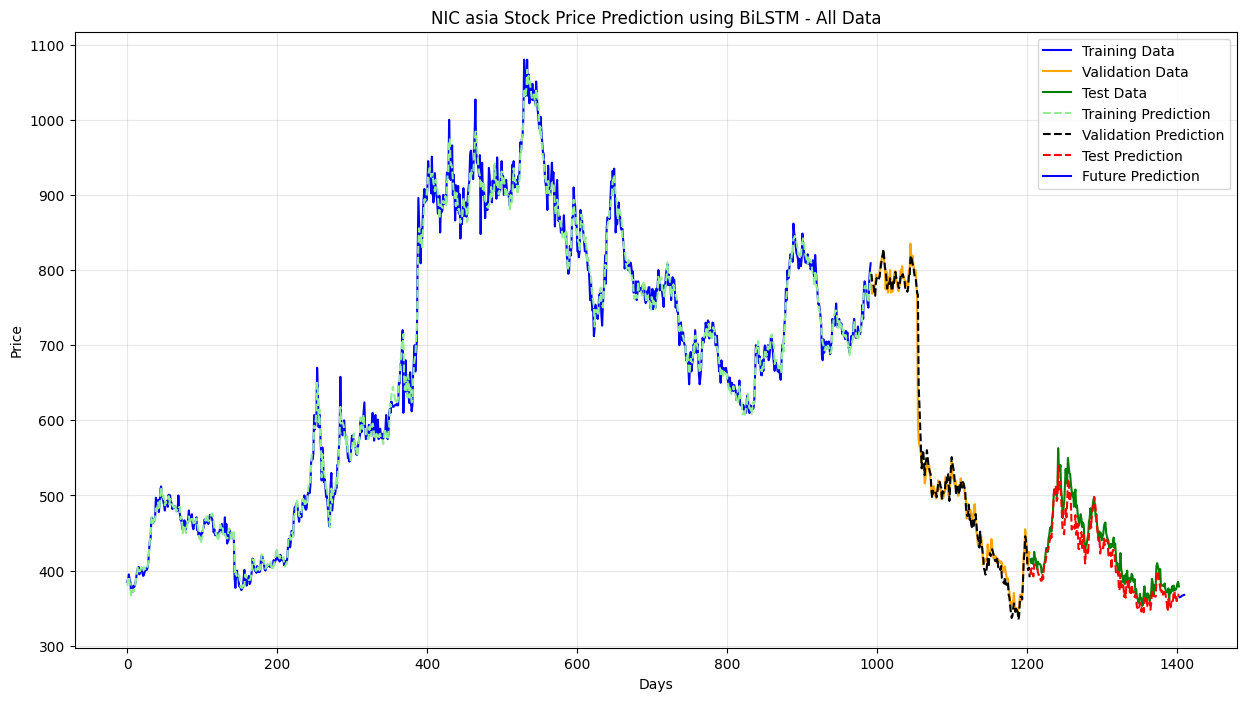

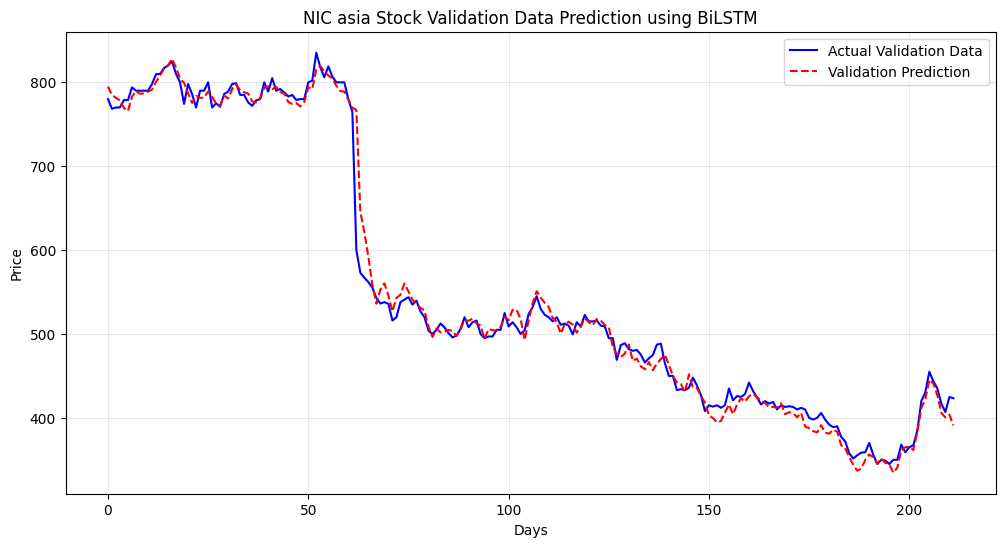

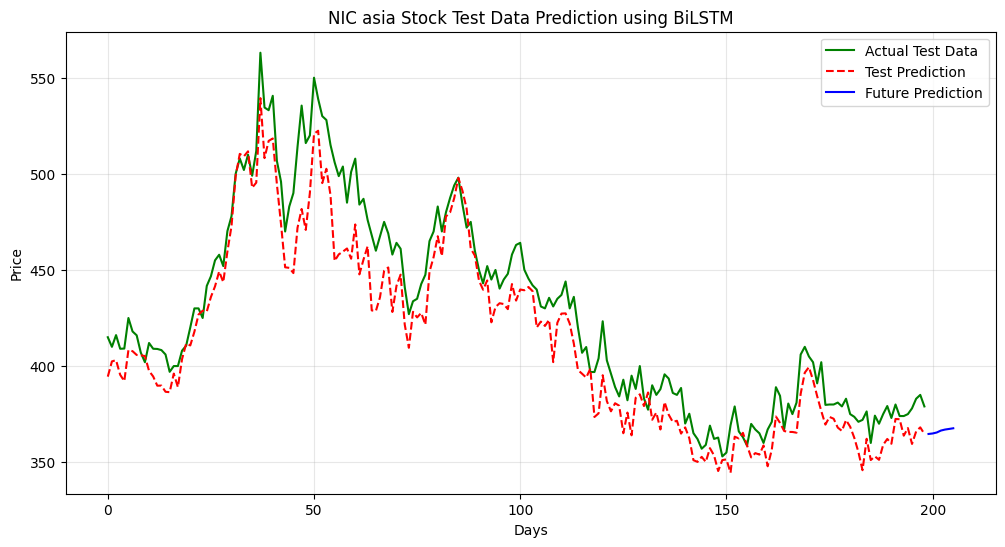


Training GRU model...


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 15, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 15, 256)   │    201,984 │ input_layer_40[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 15, 256)   │          0 │ gru_4[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 256)       │    394,752 │ dropout_50[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, 256)       │          0 │ gru_5[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_41      │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 270)       │          0 │ dropout_51[0][0], │
│ (Concatenate)       │                   │            │ input_layer_41[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 32)        │      8,672 │ concatenate_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 1)         │         33 │ dense_57[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 605,441 (2.31 MB)

 Trainable params: 605,441 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0684 - mae: 0.1814
Epoch 1: val_loss improved from inf to 0.00495, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0628 - mae: 0.1709 - val_loss: 0.0050 - val_mae: 0.0581 - learning_rate: 0.0010
Epoch 2/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - mae: 0.0374
Epoch 2: val_loss improved from 0.00495 to 0.00210, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022 - mae: 0.0371 - val_loss: 0.0021 - val_mae: 0.0336 - learning_rate: 0.0010
Epoch 3/50
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mae: 0.0306
Epoch 3: val_loss improved from 0.00210 to 0.00145, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - mae: 0.0304 - val_loss: 0.0015 - val_mae: 0.0258 - learning_rate: 0.0010
Epoch 4/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mae: 0.0271
Epoch 4: val_loss did not improve from 0.00145
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - mae: 0.0271 - val_loss: 0.0017 - val_mae: 0.0297 - learning_rate: 0.0010
Epoch 5/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - mae: 0.0271
Epoch 5: val_loss improved from 0.00145 to 0.00116, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0013 - mae: 0.0270 - val_loss: 0.0012 - val_mae: 0.0233 - learning_rate: 0.0010
Epoch 6/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.3339e-04 - mae: 0.0230 
Epoch 6: val_loss improved from 0.00116 to 0.00096, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.3857e-04 - mae: 0.0231 - val_loss: 9.5570e-04 - val_mae: 0.0212 - learning_rate: 0.0010
Epoch 7/50
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.8674e-04 - mae: 0.0234
Epoch 7: val_loss did not improve from 0.00096
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.6282e-04 - mae: 0.0232 - val_loss: 0.0011 - val_mae: 0.0223 - learning_rate: 0.0010
Epoch 8/50
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2270e-04 - mae: 0.0217
Epoch 8: val_loss improved from 0.00096 to 0.00090, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.3465e-04 - mae: 0.0218 - val_loss: 9.0430e-04 - val_mae: 0.0219 - learning_rate: 0.0010
Epoch 9/50
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6452e-04 - mae: 0.0235
Epoch 9: val_loss improved from 0.00090 to 0.00075, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.3827e-04 - mae: 0.0231 - val_loss: 7.5058e-04 - val_mae: 0.0185 - learning_rate: 0.0010
Epoch 10/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1618e-04 - mae: 0.0198
Epoch 10: val_loss did not improve from 0.00075
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1757e-04 - mae: 0.0198 - val_loss: 7.8623e-04 - val_mae: 0.0184 - learning_rate: 0.0010
Epoch 11/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9668e-04 - mae: 0.0192
Epoch 11: val_loss improved from 0.00075 to 0.00066, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.9061e-04 - mae: 0.0192 - val_loss: 6.5612e-04 - val_mae: 0.0170 - learning_rate: 0.0010
Epoch 12/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7525e-04 - mae: 0.0173
Epoch 12: val_loss improved from 0.00066 to 0.00062, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7872e-04 - mae: 0.0174 - val_loss: 6.2282e-04 - val_mae: 0.0157 - learning_rate: 0.0010
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3386e-04 - mae: 0.0169
Epoch 13: val_loss improved from 0.00062 to 0.00057, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.3498e-04 - mae: 0.0169 - val_loss: 5.6503e-04 - val_mae: 0.0137 - learning_rate: 0.0010
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8604e-04 - mae: 0.0187
Epoch 14: val_loss did not improve from 0.00057
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8440e-04 - mae: 0.0187 - val_loss: 6.2380e-04 - val_mae: 0.0149 - learning_rate: 0.0010
Epoch 15/50
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8080e-04 - mae: 0.0177
Epoch 15: val_loss improved from 0.00057 to 0.00053, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.7598e-04 - mae: 0.0176 - val_loss: 5.2812e-04 - val_mae: 0.0130 - learning_rate: 0.0010
Epoch 16/50
24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5414e-04 - mae: 0.0159
Epoch 16: val_loss did not improve from 0.00053
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6046e-04 - mae: 0.0160 - val_loss: 6.7094e-04 - val_mae: 0.0168 - learning_rate: 0.0010
Epoch 17/50
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7298e-04 - mae: 0.0162
Epoch 17: val_loss improved from 0.00053 to 0.00050, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.7680e-04 - mae: 0.0162 - val_loss: 5.0347e-04 - val_mae: 0.0123 - learning_rate: 0.0010
Epoch 18/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8130e-04 - mae: 0.0162
Epoch 18: val_loss improved from 0.00050 to 0.00047, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8494e-04 - mae: 0.0162 - val_loss: 4.6845e-04 - val_mae: 0.0118 - learning_rate: 0.0010
Epoch 19/50
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1237e-04 - mae: 0.0154
Epoch 19: val_loss improved from 0.00047 to 0.00046, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2463e-04 - mae: 0.0155 - val_loss: 4.6220e-04 - val_mae: 0.0117 - learning_rate: 0.0010
Epoch 20/50
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0438e-04 - mae: 0.0156
Epoch 20: val_loss did not improve from 0.00046
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.8896e-04 - mae: 0.0154 - val_loss: 5.2644e-04 - val_mae: 0.0128 - learning_rate: 0.0010
Epoch 21/50
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1335e-04 - mae: 0.0163
Epoch 21: val_loss did not improve from 0.00046
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1298e-04 - mae: 0.0163 - val_loss: 5.3601e-04 - val_mae: 0.0148 - learning_rate: 0.0010
Epoch 22/50
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5604e-04 - mae: 0.0171
Epoch 22: val_loss improved from 0.00046 to 0.00044, saving model to best_GRU_model.h5



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.4311e-04 - mae: 0.0169 - val_loss: 4.4448e-04 - val_mae: 0.0118 - learning_rate: 0.0010
Epoch 23/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5271e-04 - mae: 0.0152
Epoch 23: val_loss improved from 0.00044 to 0.00043, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.5113e-04 - mae: 0.0152 - val_loss: 4.3178e-04 - val_mae: 0.0106 - learning_rate: 5.0000e-04
Epoch 24/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9346e-04 - mae: 0.0145
Epoch 24: val_loss did not improve from 0.00043
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.9315e-04 - mae: 0.0144 - val_loss: 4.3826e-04 - val_mae: 0.0112 - learning_rate: 5.0000e-04
Epoch 25/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6982e-04 - mae: 0.0138
Epoch 25: val_loss did not improve from 0.00043
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.7070e-04 - mae: 0.0138 - val_loss: 5.8686e-04 - val_mae: 0.0144 - learning_rate: 5.0000e-04
Epoch 26/50
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7636e-04 - mae: 0.0153
Epoch 26: val_loss did not improve from 0.00043
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.7389e-04 - mae: 0.0153 - val_loss: 5.7151e-04 - val_mae: 0.0143 - learning_rate: 5.0000e-04
Epoch 27/50
25/31 ━━━━━━━━━━━━━━━━


Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.0828e-04 - mae: 0.0150 - val_loss: 4.1493e-04 - val_mae: 0.0102 - learning_rate: 5.0000e-04
Epoch 28/50
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0845e-04 - mae: 0.0126
Epoch 28: val_loss improved from 0.00041 to 0.00041, saving model to best_GRU_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1540e-04 - mae: 0.0127 - val_loss: 4.1036e-04 - val_mae: 0.0103 - learning_rate: 2.5000e-04
Epoch 29/50
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3413e-04 - mae: 0.0133
Epoch 29: val_loss did not improve from 0.00041
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4068e-04 - mae: 0.0134 - val_loss: 4.2429e-04 - val_mae: 0.0103 - learning_rate: 2.5000e-04
Epoch 30/50
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6845e-04 - mae: 0.0130
Epoch 30: val_loss did not improve from 0.00041
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6741e-04 - mae: 0.0130 - val_loss: 4.1597e-04 - val_mae: 0.0104 - learning_rate: 2.5000e-04
Epoch 31/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7457e-04 - mae: 0.0139
Epoch 31: val_loss did not improve from 0.00041
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.7446e-04 - mae: 0.0138 - val_loss: 4.1137e-04 - val_mae: 0.0101 - learning_rate: 2.5000e-04
Epoch 32/50
25/31 ━━━━━━━━━━━━━━━━━━━━

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
GRU - Training Data - MAE: 7.8357, MAPE: 1.11%
GRU - Validation Data - MAE: 7.5591, MAPE: 1.47%
GRU - Test Data - MAE: 8.3680, MAPE: 2.06%

--------------------------------------------------
Predicting next 7 days using GRU model...
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 1 (2025-04-19): Predicted Price = Rs.385.10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Day 2 (2025-04-20): Predicted Price = Rs.385.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Day 3 (2025-04-21): Predicted Price = Rs.385.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Day 4 (2025-04-22): Predicted Price = Rs.385.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Day 5 (2025-04-23): Predicted Price = Rs.385.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Day 6 (2025-04-24): Predicted Price = Rs.385.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Day 7 (2025-04-25): Predicted Price = Rs.385.83

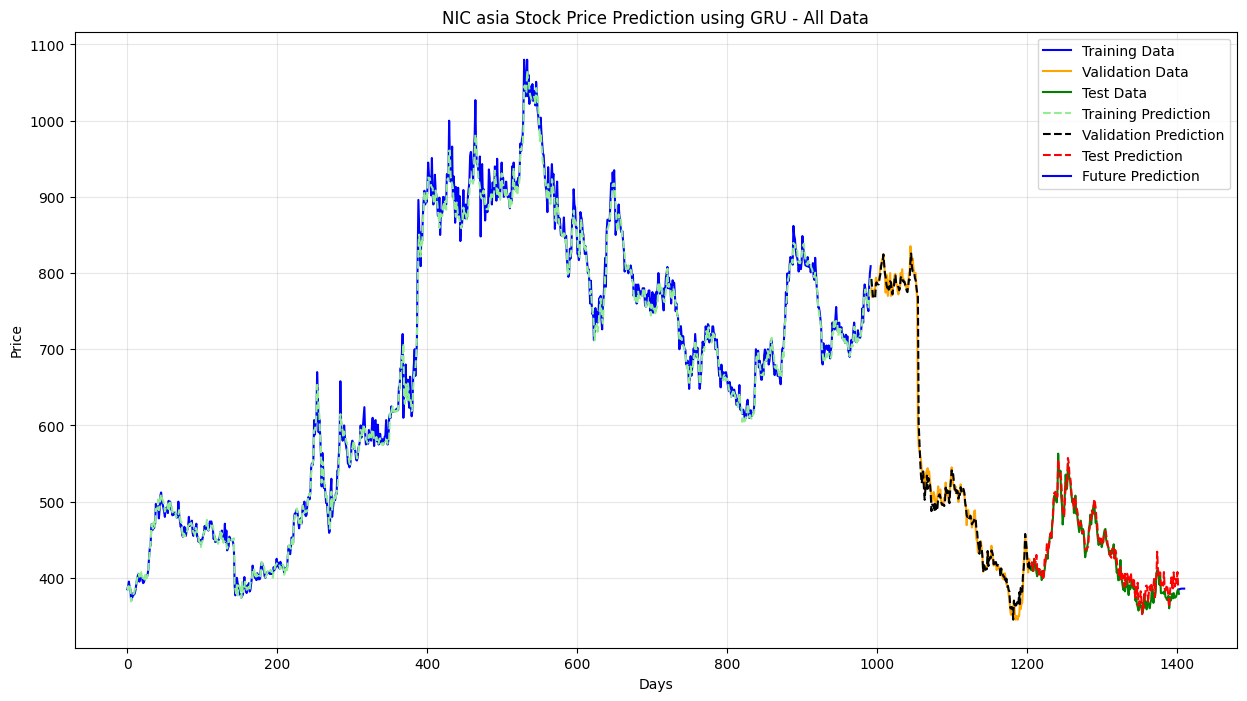

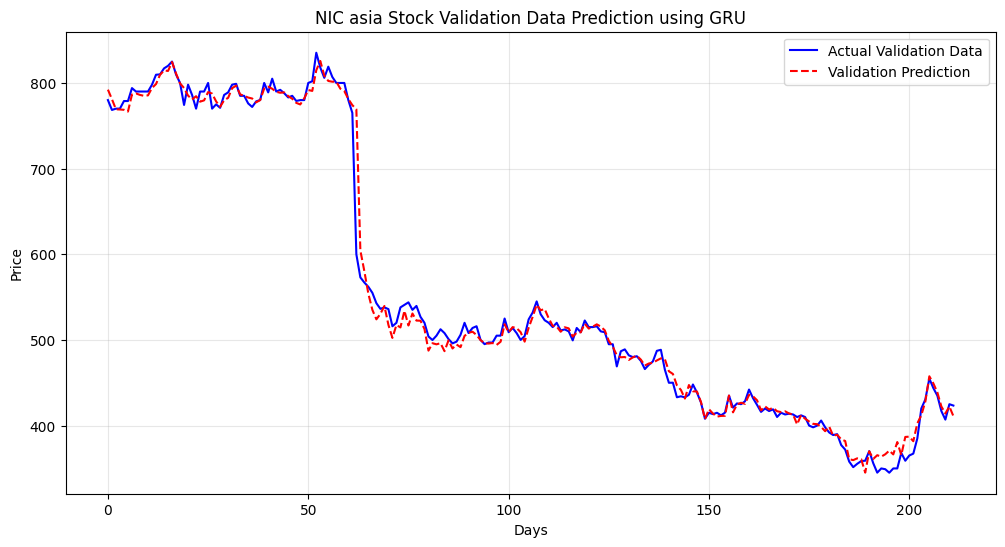

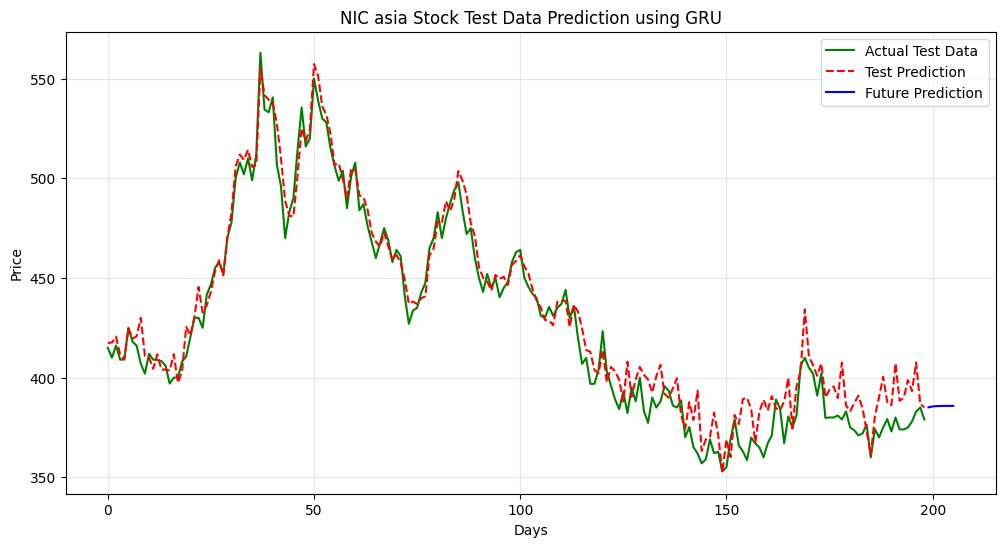


Training Transformer model...


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 15, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 15, 256)   │      1,536 │ input_layer_42[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 15, 256)   │          0 │ dense_59[0][0]    │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_24       │ (None, 15, 256)   │  1,315,840 │ positional_encod… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_25       │ (None, 15, 256)   │  1,315,840 │ functional_24[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_26       │ (None, 15, 256)   │  1,315,840 │ functional_25[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_27       │ (None, 15, 256)   │  1,315,840 │ functional_26[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ functional_27[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_47      │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 270)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ input_layer_47[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 32)        │      8,672 │ concatenate_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 1)         │         33 │ dense_68[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,273,601 (20.12 MB)

 Trainable params: 5,273,601 (20.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 10.5191 - mae: 1.2922
Epoch 1: val_loss improved from inf to 0.08181, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step - loss: 10.3004 - mae: 1.2697 - val_loss: 0.0818 - val_mae: 0.2611 - learning_rate: 0.0010
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0558 - mae: 0.1985
Epoch 2: val_loss did not improve from 0.08181
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0559 - mae: 0.1987 - val_loss: 0.1529 - val_mae: 0.3367 - learning_rate: 0.0010
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0574 - mae: 0.2021
Epoch 3: val_loss did not improve from 0.08181
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0572 - mae: 0.2018 - val_loss: 0.1016 - val_mae: 0.2724 - learning_rate: 0.0010
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0480 - mae: 0.1834
Epoch 4: val_loss did not improve from 0.08181
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0479 - mae: 0.1833 - val_loss: 0.0893 - val_mae: 0.2574 - learning_rate: 0.0010
Epoch 5/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0433 - mae: 0.1753
Epoch 5: val_los

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0431 - mae: 0.1750 - val_loss: 0.0462 - val_mae: 0.2040 - learning_rate: 0.0010
Epoch 6/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0440 - mae: 0.1780
Epoch 6: val_loss did not improve from 0.04618
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0439 - mae: 0.1779 - val_loss: 0.0583 - val_mae: 0.2177 - learning_rate: 0.0010
Epoch 7/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0319 - mae: 0.1517
Epoch 7: val_loss improved from 0.04618 to 0.02669, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0317 - mae: 0.1512 - val_loss: 0.0267 - val_mae: 0.1548 - learning_rate: 0.0010
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0286 - mae: 0.1434
Epoch 8: val_loss improved from 0.02669 to 0.02363, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0286 - mae: 0.1433 - val_loss: 0.0236 - val_mae: 0.1472 - learning_rate: 0.0010
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0209 - mae: 0.1219
Epoch 9: val_loss did not improve from 0.02363
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0209 - mae: 0.1217 - val_loss: 0.0423 - val_mae: 0.1832 - learning_rate: 0.0010
Epoch 10/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0335 - mae: 0.1392
Epoch 10: val_loss did not improve from 0.02363
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0341 - mae: 0.1409 - val_loss: 0.0272 - val_mae: 0.1151 - learning_rate: 0.0010
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0290 - mae: 0.1377
Epoch 11: val_loss improved from 0.02363 to 0.01815, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0289 - mae: 0.1374 - val_loss: 0.0181 - val_mae: 0.1209 - learning_rate: 0.0010
Epoch 12/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0212 - mae: 0.1208
Epoch 12: val_loss improved from 0.01815 to 0.01674, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0213 - mae: 0.1207 - val_loss: 0.0167 - val_mae: 0.1186 - learning_rate: 0.0010
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0202 - mae: 0.1198
Epoch 13: val_loss did not improve from 0.01674
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0202 - mae: 0.1197 - val_loss: 0.0222 - val_mae: 0.1402 - learning_rate: 0.0010
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0135 - mae: 0.0973
Epoch 14: val_loss improved from 0.01674 to 0.01652, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0135 - mae: 0.0972 - val_loss: 0.0165 - val_mae: 0.1220 - learning_rate: 0.0010
Epoch 15/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0121 - mae: 0.0908
Epoch 15: val_loss improved from 0.01652 to 0.01310, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0120 - mae: 0.0907 - val_loss: 0.0131 - val_mae: 0.1068 - learning_rate: 0.0010
Epoch 16/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0110 - mae: 0.0868
Epoch 16: val_loss improved from 0.01310 to 0.01155, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0110 - mae: 0.0868 - val_loss: 0.0115 - val_mae: 0.0989 - learning_rate: 0.0010
Epoch 17/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0091 - mae: 0.0784
Epoch 17: val_loss improved from 0.01155 to 0.01055, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0091 - mae: 0.0785 - val_loss: 0.0105 - val_mae: 0.0946 - learning_rate: 0.0010
Epoch 18/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0107 - mae: 0.0840
Epoch 18: val_loss did not improve from 0.01055
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0108 - mae: 0.0842 - val_loss: 0.0223 - val_mae: 0.1285 - learning_rate: 0.0010
Epoch 19/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0084 - mae: 0.0725
Epoch 19: val_loss improved from 0.01055 to 0.00801, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0083 - mae: 0.0724 - val_loss: 0.0080 - val_mae: 0.0711 - learning_rate: 0.0010
Epoch 20/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0074 - mae: 0.0691
Epoch 20: val_loss did not improve from 0.00801
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0074 - mae: 0.0690 - val_loss: 0.0095 - val_mae: 0.0891 - learning_rate: 0.0010
Epoch 21/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0057 - mae: 0.0602
Epoch 21: val_loss improved from 0.00801 to 0.00630, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0057 - mae: 0.0603 - val_loss: 0.0063 - val_mae: 0.0660 - learning_rate: 0.0010
Epoch 22/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0058 - mae: 0.0604
Epoch 22: val_loss did not improve from 0.00630
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0058 - mae: 0.0605 - val_loss: 0.0117 - val_mae: 0.0941 - learning_rate: 0.0010
Epoch 23/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0055 - mae: 0.0595
Epoch 23: val_loss did not improve from 0.00630
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0055 - mae: 0.0594 - val_loss: 0.0070 - val_mae: 0.0747 - learning_rate: 0.0010
Epoch 24/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0048 - mae: 0.0544
Epoch 24: val_loss did not improve from 0.00630
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0048 - mae: 0.0544 - val_loss: 0.0067 - val_mae: 0.0728 - learning_rate: 0.0010
Epoch 25/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0056 - mae: 0.0593
Epoch 25: va

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0056 - mae: 0.0592 - val_loss: 0.0056 - val_mae: 0.0664 - learning_rate: 0.0010
Epoch 26/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0038 - mae: 0.0483
Epoch 26: val_loss improved from 0.00560 to 0.00398, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0038 - mae: 0.0484 - val_loss: 0.0040 - val_mae: 0.0544 - learning_rate: 0.0010
Epoch 27/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0038 - mae: 0.0484
Epoch 27: val_loss did not improve from 0.00398
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0038 - mae: 0.0484 - val_loss: 0.0045 - val_mae: 0.0487 - learning_rate: 0.0010
Epoch 28/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0045 - mae: 0.0530
Epoch 28: val_loss improved from 0.00398 to 0.00325, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0045 - mae: 0.0529 - val_loss: 0.0032 - val_mae: 0.0418 - learning_rate: 0.0010
Epoch 29/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0037 - mae: 0.0469
Epoch 29: val_loss did not improve from 0.00325
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0037 - mae: 0.0470 - val_loss: 0.0039 - val_mae: 0.0540 - learning_rate: 0.0010
Epoch 30/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0043 - mae: 0.0516
Epoch 30: val_loss improved from 0.00325 to 0.00286, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0043 - mae: 0.0515 - val_loss: 0.0029 - val_mae: 0.0382 - learning_rate: 0.0010
Epoch 31/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0032 - mae: 0.0434
Epoch 31: val_loss improved from 0.00286 to 0.00240, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0032 - mae: 0.0434 - val_loss: 0.0024 - val_mae: 0.0404 - learning_rate: 0.0010
Epoch 32/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0027 - mae: 0.0399
Epoch 32: val_loss did not improve from 0.00240
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0027 - mae: 0.0400 - val_loss: 0.0044 - val_mae: 0.0533 - learning_rate: 0.0010
Epoch 33/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0037 - mae: 0.0487
Epoch 33: val_loss improved from 0.00240 to 0.00216, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0037 - mae: 0.0486 - val_loss: 0.0022 - val_mae: 0.0333 - learning_rate: 0.0010
Epoch 34/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0029 - mae: 0.0411
Epoch 34: val_loss improved from 0.00216 to 0.00199, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0029 - mae: 0.0410 - val_loss: 0.0020 - val_mae: 0.0320 - learning_rate: 0.0010
Epoch 35/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0030 - mae: 0.0423
Epoch 35: val_loss improved from 0.00199 to 0.00180, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0030 - mae: 0.0423 - val_loss: 0.0018 - val_mae: 0.0340 - learning_rate: 0.0010
Epoch 36/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0029 - mae: 0.0418
Epoch 36: val_loss did not improve from 0.00180
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0029 - mae: 0.0418 - val_loss: 0.0020 - val_mae: 0.0315 - learning_rate: 0.0010
Epoch 37/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0025 - mae: 0.0384
Epoch 37: val_loss did not improve from 0.00180
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0025 - mae: 0.0385 - val_loss: 0.0032 - val_mae: 0.0456 - learning_rate: 0.0010
Epoch 38/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0029 - mae: 0.0430
Epoch 38: val_loss did not improve from 0.00180
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - mae: 0.0430 - val_loss: 0.0025 - val_mae: 0.0387 - learning_rate: 0.0010
Epoch 39/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0022 - mae: 0.0366
Epoch 39: va

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0029 - mae: 0.0423 - val_loss: 0.0013 - val_mae: 0.0258 - learning_rate: 5.0000e-04
Epoch 42/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0019 - mae: 0.0333
Epoch 42: val_loss improved from 0.00127 to 0.00125, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0019 - mae: 0.0333 - val_loss: 0.0013 - val_mae: 0.0255 - learning_rate: 5.0000e-04
Epoch 43/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0019 - mae: 0.0335
Epoch 43: val_loss did not improve from 0.00125
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0019 - mae: 0.0335 - val_loss: 0.0020 - val_mae: 0.0339 - learning_rate: 5.0000e-04
Epoch 44/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0017 - mae: 0.0315
Epoch 44: val_loss did not improve from 0.00125
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0017 - mae: 0.0315 - val_loss: 0.0014 - val_mae: 0.0274 - learning_rate: 5.0000e-04
Epoch 45/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0016 - mae: 0.0307
Epoch 45: val_loss did not improve from 0.00125
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0016 - mae: 0.0307 - val_loss: 0.0015 - val_mae: 0.0282 - learning_rate: 5.0000e-04
Epoch 46/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0017 - mae: 0.0

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0016 - mae: 0.0313 - val_loss: 0.0012 - val_mae: 0.0249 - learning_rate: 2.5000e-04
Epoch 48/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0017 - mae: 0.0311
Epoch 48: val_loss improved from 0.00122 to 0.00114, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0017 - mae: 0.0312 - val_loss: 0.0011 - val_mae: 0.0241 - learning_rate: 2.5000e-04
Epoch 49/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0017 - mae: 0.0323
Epoch 49: val_loss did not improve from 0.00114
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0017 - mae: 0.0323 - val_loss: 0.0012 - val_mae: 0.0251 - learning_rate: 2.5000e-04
Epoch 50/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0017 - mae: 0.0312
Epoch 50: val_loss improved from 0.00114 to 0.00111, saving model to best_Transformer_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0016 - mae: 0.0312 - val_loss: 0.0011 - val_mae: 0.0242 - learning_rate: 2.5000e-04
Weights loaded successfully!
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
Transformer - Training Data - MAE: 20.9597, MAPE: 3.41%
Transformer - Validation Data - MAE: 17.8071, MAPE: 3.28%
Transformer - Test Data - MAE: 16.3360, MAPE: 3.83%

--------------------------------------------------
Predicting next 7 days using Transformer model...
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
Day 1 (2025-04-19): Predicted Price = Rs.356.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Day 2 (2025-04-20): Predicted Price = Rs.356.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Day 3 (2025-04-21): Predicted Price = Rs.356.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Day 4 (2025-04-22): Predicted Price = Rs.356.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Day 5 (2025-04-23)

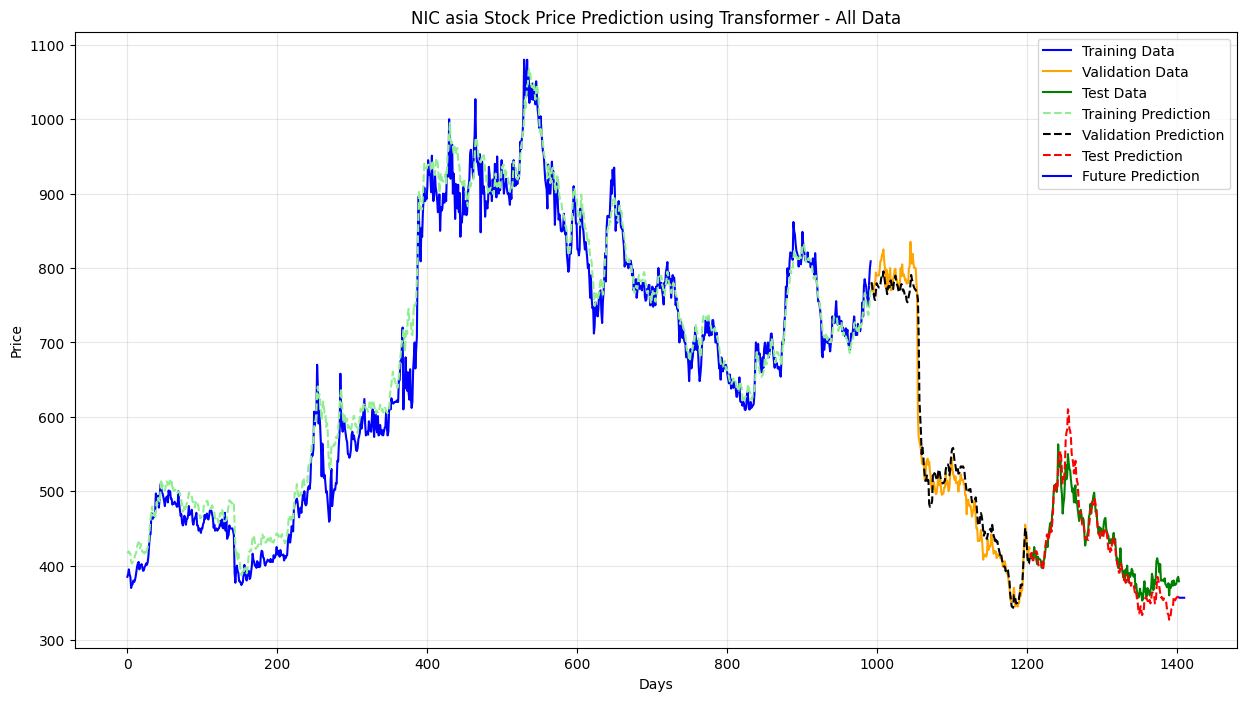

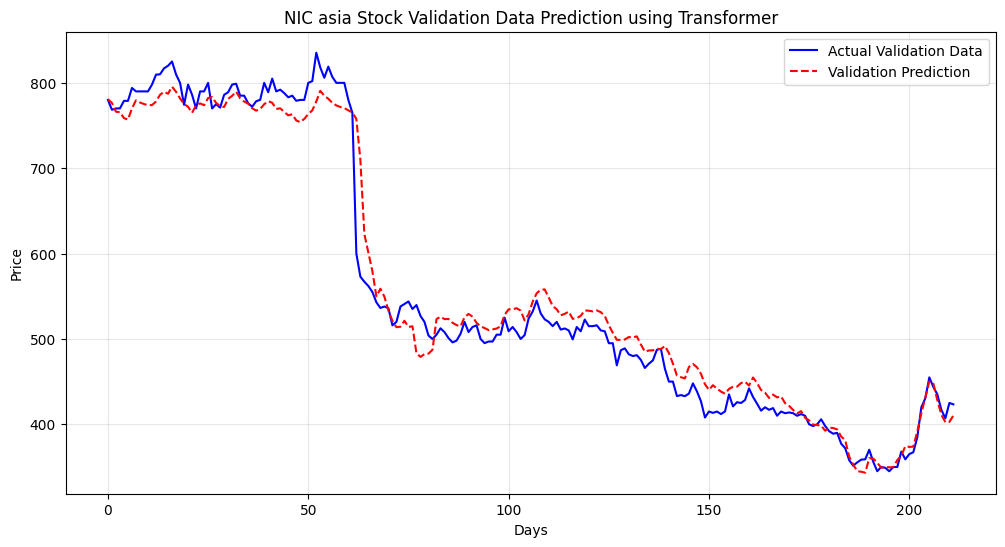

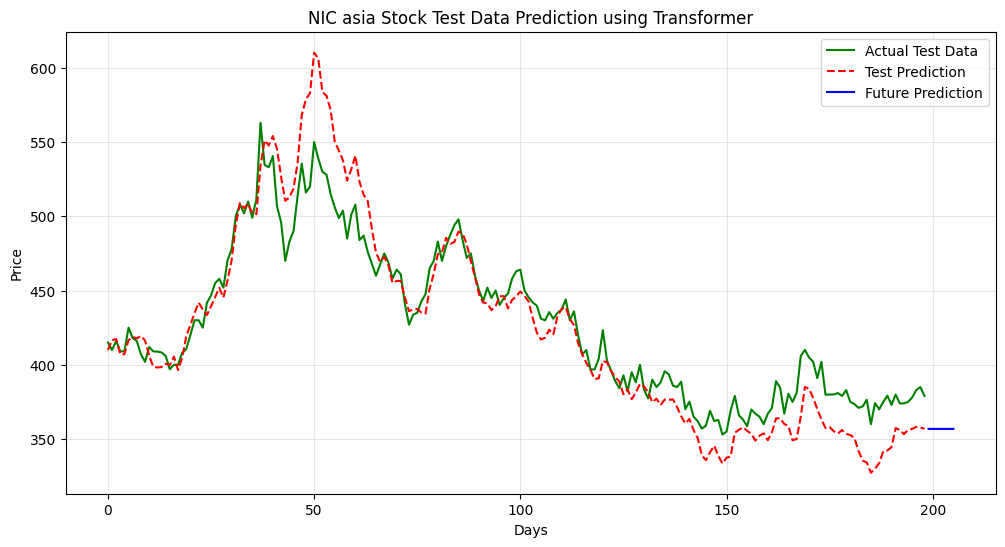


Model Performance Comparison:
         Model  Train MAE  Train MAPE (%)    Val MAE  Val MAPE (%)   Test MAE  \
0         LSTM   7.743851        1.135450  10.018035      1.909961   8.450178   
1       BiLSTM   8.161035        1.176569   9.535124      1.849382  15.350422   
2          GRU   7.835651        1.111611   7.559109      1.467166   8.367961   
3  Transformer  20.959672        3.410522  17.807147      3.277601  16.336048   

   Test MAPE (%)  
0       2.048614  
1       3.526462  
2       2.060180  
3       3.825790  


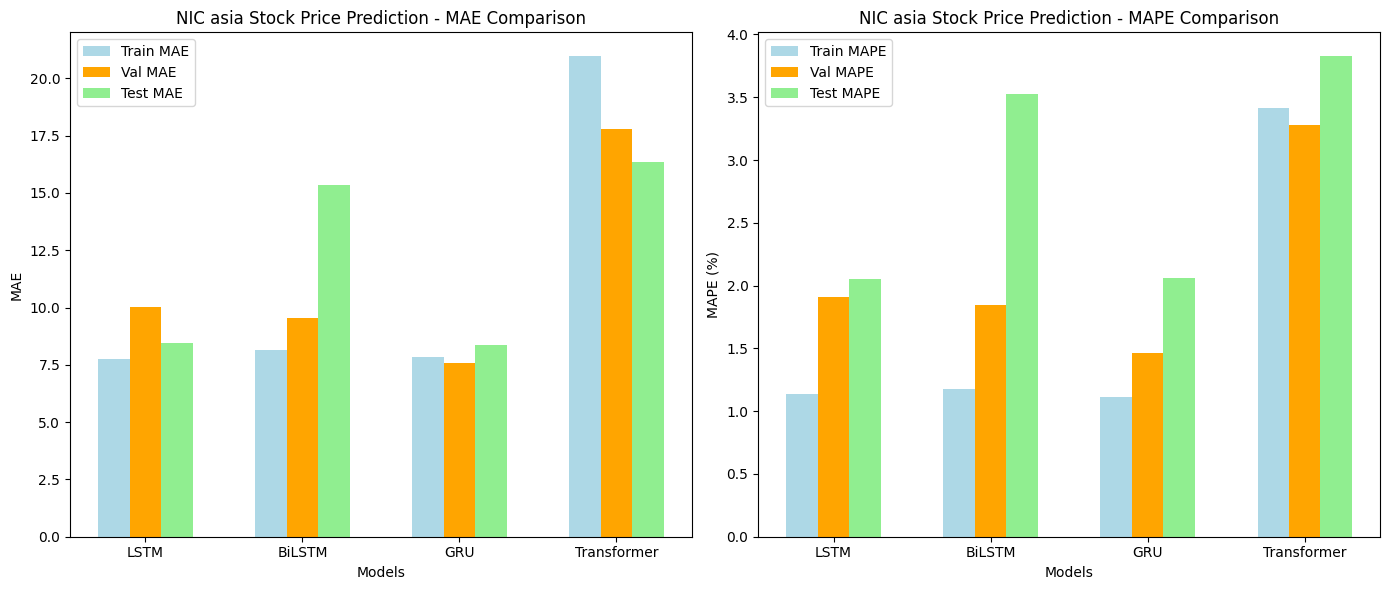

In [25]:
# Run models
model_results, metrics_df = run_models(
    X_seq_train, X_ind_train, y_train,
    X_seq_val, X_ind_val, y_val,
    X_seq_test, X_ind_test, y_test,
    SEQ_LEN, seq_features, num_indicators,
    scaler_y=scaler,
    epochs=50,
    batch_size=32,
    stock_name="NIC asia Stock"
)